In [ ]:
%pylab inline
!pip install uncertainties
from uncertainties import ufloat
from uncertainties.umath import * 
import pandas as pd
import scipy as sp
from uncertainties import unumpy
from scipy.constants import *
from scipy import stats
from scipy.signal import find_peaks
import csv
from collections import Counter
import sklearn.linear_model
import sklearn.model_selection

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['bar', 'fabs', 'tanh', 'sin', 'degrees', 'floor', 'modf', 'exp', 'expm1', 'pi', 'ldexp', 'isnan', 'fmod', 'tan', 'gamma', 'sinh', 'copysign', 'trunc', 'log10', 'cosh', 'log', 'cos', 'radians', 'sqrt', 'ceil', 'e', 'frexp', 'hypot', 'log1p', 'isinf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# **Bogota**

In [ ]:
import requests
import json
C1 = requests.get('https://www.datos.gov.co/resource/vkjr-c6fe.json?ndepto=BOGOTA D.C.&$limit=500000&npuesto=LA PONDEROSA').text
C2 = requests.get('https://www.datos.gov.co/resource/75f2-fe2s.json?ndepto=BOGOTA D.C.&$limit=500000&npuesto=CORFERIAS').text

In [ ]:
Camara = json.loads(C1)
shape(Camara)

(1541,)

In [ ]:
Senado = json.loads(C2)
shape(Senado)

(0,)

In [ ]:
Mesas = linspace(1,19,19)
mesa_1 = [d for d in Camara if d['mesa'] in str(Mesas[0])]

In [ ]:
N_votos_1 = 0
for i in mesa_1:
    N_votos_1 += int(i['votos'])
N_votos_1

217

In [ ]:
for i in mesa_1:
    if i['candidato'] == 'VOTOS EN BLANCO' and i['ncircunscripcion'] == 'TERRITORIAL DEPARTAMENTAL':
        N_votos_blanco = int(i['votos'])
N_votos_blanco

12

In [ ]:
N_votos = []
N_votos_blanco = []
for i in Mesas:
    count_votos = 0
    count_mesas = 0
    A = [d for d in Camara if d['mesa'] in str(i)]
    for j in A:
        count_votos += int(j['votos'])
        try:
            if j['candidato'] == 'VOTOS EN BLANCO' and j['ncircunscripcion'] == 'TERRITORIAL DEPARTAMENTAL':
                count_mesas += int(j['votos'])
                # print(j)
        except Exception:
            pass
    N_votos_blanco.append(count_mesas)
    N_votos.append(count_votos)

In [ ]:
sum(N_votos)

8335

In [ ]:
print(len(N_votos), len(N_votos_blanco))

19 19


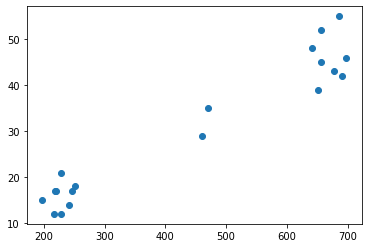

In [ ]:
scatter(N_votos,N_votos_blanco)

In [ ]:
x_obs = np.array(N_votos)
y_obs = np.array(N_votos_blanco)

def modelo(x_obs, m, b):
    return(x_obs*m + b)

In [ ]:
def loglikelihood(x_obs, y_obs, m, b):
    y_modelo = modelo(x_obs, m, b)
    x = -0.5*np.sum(((y_modelo - y_obs))**2)
    return x

In [ ]:
n_iteraciones = 100000
m_walk = np.zeros(n_iteraciones)
b_walk = np.zeros(n_iteraciones)

for i in range(1,n_iteraciones):
    m_prime = np.random.normal(m_walk[i-1],0.05)
    b_prime = np.random.normal(b_walk[i-1],0.05)

    l_now = loglikelihood(x_obs,y_obs, m_walk[i-1], b_walk[i-1])
    l_next = loglikelihood(x_obs,y_obs, m_prime, b_prime)
    gamma = np.min([1.0,np.exp(l_next-l_now)])
    # print(gamma)

    alpha = np.random.random()
    if alpha<gamma:
        m_walk[i] = m_prime
        b_walk[i] = b_prime
    else:
        m_walk[i] = m_walk[i-1]
        b_walk[i] = b_walk[i-1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
m_best = np.mean(m_walk)
m_error = np.std(m_walk)
print(m_best, m_error)

0.06798494563013124 0.0008865581895555676


In [ ]:
b_best = np.mean(b_walk)
b_error = np.std(b_walk)
print(b_best, b_error)

0.5582311825604388 0.3534740557401596


In [ ]:
x_teorico = np.linspace(x_obs.min(), x_obs.max(),1000)
y_teorico = modelo(x_teorico, m_best, b_best)

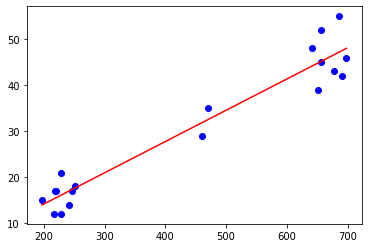

In [ ]:
plt.scatter(N_votos,N_votos_blanco, c = 'b')
plt.plot(x_teorico, y_teorico, c = 'r')

In [472]:
B1 = requests.get('https://www.datos.gov.co/resource/vkjr-c6fe.json?ndepto=BOGOTA D.C.&$limit=500000&$order=npuesto ASC').text
B2 = requests.get('https://www.datos.gov.co/resource/vkjr-c6fe.json?ndepto=BOGOTA D.C.&$limit=500000&$offset=500000&$order=npuesto ASC').text

In [473]:
B1 = json.loads(B1)
shape(B1)

(500000,)

In [474]:
B2 = json.loads(B2)
shape(B2)

(456162,)

In [475]:
B = B1 + B2
shape(B)

(956162,)

In [476]:
A = [0,1,2,3,4,5,6,7,8]
A[:2]

[0, 1]

**Ajuste con numero de votos con CORFERIAS**

In [477]:
n = B[0]['npuesto']
b_votos = 0
n_votos = 0
A = []
for i in B:
    if i['npuesto'] == n:
        n_votos += int(i['votos'])
        try:
            if i['candidato'] == 'VOTOS EN BLANCO':
                b_votos += int(i['votos'])
        except Exception:
            pass
    else:
        A.append([n,n_votos,b_votos])
        n = i['npuesto']
        n_votos = int(i['votos'])
        b_votos = 0
shape(A)

(641, 3)

In [478]:
n = B[0]['npuesto']
nulos_votos = 0
n_votos = 0
A2 = []
for i in B:
    if i['npuesto'] == n:
        n_votos += int(i['votos'])
        try:
            if i['candidato'] == 'VOTOS NULOS':
                nulos_votos += int(i['votos'])
        except Exception:
            pass
    else:
        A2.append([n,n_votos,nulos_votos])
        n = i['npuesto']
        n_votos = int(i['votos'])
        nulos_votos = 0
shape(A)

(641, 3)

In [479]:
n = B[0]['npuesto']
nmarcados_votos = 0
n_votos = 0
A3 = []
for i in B:
    if i['npuesto'] == n:
        n_votos += int(i['votos'])
        try:
            if i['candidato'] == 'VOTOS NO MARCADOS':
                nmarcados_votos += int(i['votos'])
        except Exception:
            pass
    else:
        A3.append([n,n_votos,nmarcados_votos])
        n = i['npuesto']
        n_votos = int(i['votos'])
        nmarcados_votos = 0
shape(A)

(641, 3)

In [480]:
A = np.array(A)
A2 = np.array(A2)
A3 = np.array(A3)
VOTOS = [int(x) for x in A[:,1]]
BLANCO = [int(x) for x in A[:,2]]
NULOS = [int(x) for x in A2[:,2]]
NO_MARCADOS = [int(x) for x in A3[:,2]]

Text(0.5, 1.0, 'Camara - Bogota')

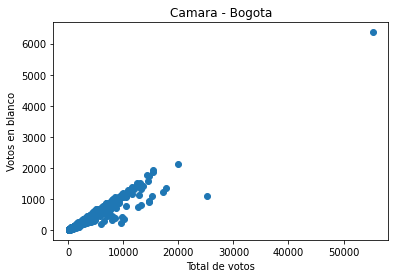

In [481]:
scatter(VOTOS,BLANCO)
xlabel('Total de votos')
ylabel('Votos en blanco')
title('Camara - Bogota')

Text(0.5, 1.0, 'Camara - Bogota')

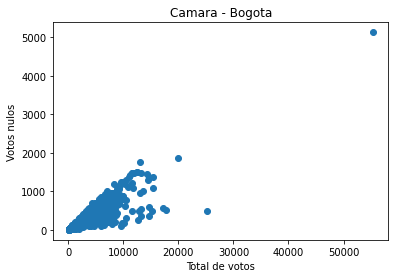

In [482]:
scatter(VOTOS,NULOS)
xlabel('Total de votos')
ylabel('Votos nulos')
title('Camara - Bogota')

Text(0.5, 1.0, 'Camara - Bogota')

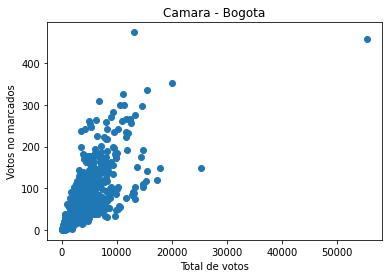

In [483]:
scatter(VOTOS,NO_MARCADOS)
xlabel('Total de votos')
ylabel('Votos no marcados')
title('Camara - Bogota')

**Blanco**

In [484]:
x_obs = np.array(VOTOS)
y_obs = np.array(BLANCO)

In [485]:
for i in range(1,n_iteraciones):
    m_prime = np.random.normal(m_walk[i-1],0.05)
    b_prime = np.random.normal(b_walk[i-1],0.05)

    l_now = loglikelihood(x_obs,y_obs, m_walk[i-1], b_walk[i-1])
    l_next = loglikelihood(x_obs,y_obs, m_prime, b_prime)
    gamma = np.min([1.0,np.exp(l_next-l_now)])
    # print(gamma)

    alpha = np.random.random()
    if alpha<gamma:
        m_walk[i] = m_prime
        b_walk[i] = b_prime
    else:
        m_walk[i] = m_walk[i-1]
        b_walk[i] = b_walk[i-1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


In [486]:
m_best = np.mean(m_walk)
m_error = np.std(m_walk)
print(m_best, m_error)

0.10146419706927928 0.00041456775550824246


In [487]:
b_best = np.mean(b_walk)
b_error = np.std(b_walk)
print(b_best, b_error)

0.7927632643574799 0.4231748929368418


In [488]:
x_teorico = np.linspace(x_obs.min(), x_obs.max(),1000)
y_teorico = modelo(x_teorico, m_best, b_best)

Text(0.5, 1.0, 'Camara - Bogota')

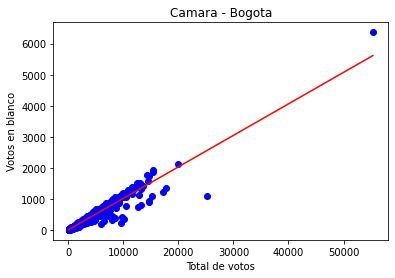

In [489]:
plt.scatter(VOTOS,BLANCO, c = 'b')
plt.plot(x_teorico, y_teorico, c = 'r')
xlabel('Total de votos')
ylabel('Votos en blanco')
title('Camara - Bogota')

In [490]:
modelo(2689646+41164+89165,m_best,b_best)

286127.2918937052

In [491]:
203889+10964+20717

235570

**Nulo**

In [492]:
x_obs = np.array(VOTOS)
y_obs = np.array(NULOS)

In [493]:
for i in range(1,n_iteraciones):
    m_prime = np.random.normal(m_walk[i-1],0.05)
    b_prime = np.random.normal(b_walk[i-1],0.05)

    l_now = loglikelihood(x_obs,y_obs, m_walk[i-1], b_walk[i-1])
    l_next = loglikelihood(x_obs,y_obs, m_prime, b_prime)
    gamma = np.min([1.0,np.exp(l_next-l_now)])
    # print(gamma)

    alpha = np.random.random()
    if alpha<gamma:
        m_walk[i] = m_prime
        b_walk[i] = b_prime
    else:
        m_walk[i] = m_walk[i-1]
        b_walk[i] = b_walk[i-1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


In [494]:
m_best = np.mean(m_walk)
m_error = np.std(m_walk)
print(m_best, m_error)

0.08318620650280899 0.00047665482248373923


In [495]:
b_best = np.mean(b_walk)
b_error = np.std(b_walk)
print(b_best, b_error)

4.826460983378576 2.4333590866133465


In [496]:
x_teorico = np.linspace(x_obs.min(), x_obs.max(),1000)
y_teorico = modelo(x_teorico, m_best, b_best)

Text(0.5, 1.0, 'Camara - Bogota')

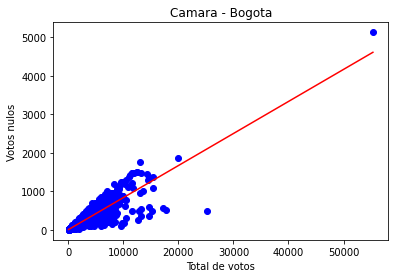

In [497]:
plt.scatter(VOTOS,NULOS, c = 'b')
plt.plot(x_teorico, y_teorico, c = 'r')
xlabel('Total de votos')
ylabel('Votos nulos')
title('Camara - Bogota')

In [498]:
modelo(2689646+41164+89165,m_best,b_best)

234587.84914374215

In [499]:
75621+3048+6692

85361

**No marcado**

In [500]:
x_obs = np.array(VOTOS)
y_obs = np.array(NO_MARCADOS)

In [501]:
for i in range(1,n_iteraciones):
    m_prime = np.random.normal(m_walk[i-1],0.05)
    b_prime = np.random.normal(b_walk[i-1],0.05)

    l_now = loglikelihood(x_obs,y_obs, m_walk[i-1], b_walk[i-1])
    l_next = loglikelihood(x_obs,y_obs, m_prime, b_prime)
    gamma = np.min([1.0,np.exp(l_next-l_now)])
    # print(gamma)

    alpha = np.random.random()
    if alpha<gamma:
        m_walk[i] = m_prime
        b_walk[i] = b_prime
    else:
        m_walk[i] = m_walk[i-1]
        b_walk[i] = b_walk[i-1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


In [502]:
m_best = np.mean(m_walk)
m_error = np.std(m_walk)
print(m_best, m_error)

0.014576706760685034 0.0002854620417415127


In [503]:
b_best = np.mean(b_walk)
b_error = np.std(b_walk)
print(b_best, b_error)

3.2407082887871472 1.7925786666668018


In [504]:
x_teorico = np.linspace(x_obs.min(), x_obs.max(),1000)
y_teorico = modelo(x_teorico, m_best, b_best)

Text(0.5, 1.0, 'Camara - Bogota')

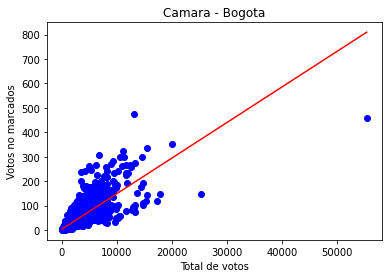

In [505]:
plt.scatter(VOTOS,NO_MARCADOS, c = 'b')
plt.plot(x_teorico, y_teorico, c = 'r')
xlabel('Total de votos')
ylabel('Votos no marcados')
title('Camara - Bogota')

In [506]:
modelo(2689646+41164+89165,m_best,b_best)

41109.189355751565

In [507]:
28944+1538+3381

33863

In [508]:
V1 = requests.get('https://www.datos.gov.co/resource/75f2-fe2s.json?ndepto=BOGOTA D.C.&$limit=500000&$order=npuesto ASC').text
V2 = requests.get('https://www.datos.gov.co/resource/75f2-fe2s.json?ndepto=BOGOTA D.C.&$limit=500000&$offset=500000&$order=npuesto ASC').text

In [509]:
V1 = json.loads(V1)
shape(V1)

(500000,)

In [510]:
V2 = json.loads(V2)
shape(V2)

(496208,)

In [511]:
V = V1 + V2
shape(V)

(996208,)

In [512]:
n = V[0]['npuesto']
b_votos = 0
n_votos = 0
A = []
for i in V:
    if i['npuesto'] == n:
        n_votos += int(i['votos'])
        try:
            if i['candidato'] == 'VOTOS EN BLANCO':
                b_votos += int(i['votos'])
        except Exception:
            pass
    else:
        A.append([n,n_votos,b_votos])
        n = i['npuesto']
        n_votos = int(i['votos'])
        b_votos = 0
shape(A)

(641, 3)

In [513]:
n = V[0]['npuesto']
nulos_votos = 0
n_votos = 0
A2 = []
for i in V:
    if i['npuesto'] == n:
        n_votos += int(i['votos'])
        try:
            if i['candidato'] == 'VOTOS NULOS':
                nulos_votos += int(i['votos'])
        except Exception:
            pass
    else:
        A2.append([n,n_votos,nulos_votos])
        n = i['npuesto']
        n_votos = int(i['votos'])
        nulos_votos = 0
shape(A)

(641, 3)

In [514]:
n = V[0]['npuesto']
nmarcados_votos = 0
n_votos = 0
A3 = []
for i in V:
    if i['npuesto'] == n:
        n_votos += int(i['votos'])
        try:
            if i['candidato'] == 'VOTOS NO MARCADOS':
                nmarcados_votos += int(i['votos'])
        except Exception:
            pass
    else:
        A3.append([n,n_votos,nmarcados_votos])
        n = i['npuesto']
        n_votos = int(i['votos'])
        nmarcados_votos = 0
shape(A)

(641, 3)

In [515]:
A = np.array(A)
A2 = np.array(A2)
A3 = np.array(A3)
VOTOS = [int(x) for x in A[:,1]]
BLANCO = [int(x) for x in A[:,2]]
NULOS = [int(x) for x in A2[:,2]]
NO_MARCADOS = [int(x) for x in A3[:,2]]

Text(0.5, 1.0, 'Senado - Bogota')

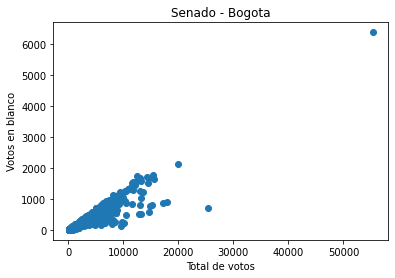

In [516]:
scatter(VOTOS,BLANCO)
xlabel('Total de votos')
ylabel('Votos en blanco')
title('Senado - Bogota')

Text(0.5, 1.0, 'Senado - Bogota')

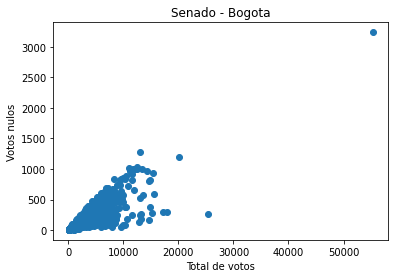

In [517]:
scatter(VOTOS,NULOS)
xlabel('Total de votos')
ylabel('Votos nulos')
title('Senado - Bogota')

Text(0.5, 1.0, 'Senado - Bogota')

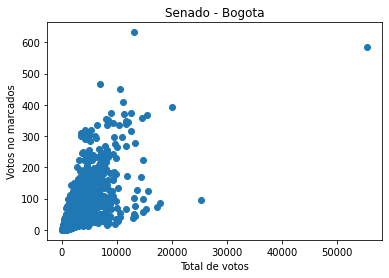

In [518]:
scatter(VOTOS,NO_MARCADOS)
xlabel('Total de votos')
ylabel('Votos no marcados')
title('Senado - Bogota')

**Blanco**

In [519]:
x_obs = np.array(VOTOS)
y_obs = np.array(BLANCO)

In [520]:
for i in range(1,n_iteraciones):
    m_prime = np.random.normal(m_walk[i-1],0.05)
    b_prime = np.random.normal(b_walk[i-1],0.05)

    l_now = loglikelihood(x_obs,y_obs, m_walk[i-1], b_walk[i-1])
    l_next = loglikelihood(x_obs,y_obs, m_prime, b_prime)
    gamma = np.min([1.0,np.exp(l_next-l_now)])
    # print(gamma)

    alpha = np.random.random()
    if alpha<gamma:
        m_walk[i] = m_prime
        b_walk[i] = b_prime
    else:
        m_walk[i] = m_walk[i-1]
        b_walk[i] = b_walk[i-1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


In [521]:
m_best = np.mean(m_walk)
m_error = np.std(m_walk)
print(m_best, m_error)

0.0977642014501047 0.0005716893587073494


In [522]:
b_best = np.mean(b_walk)
b_error = np.std(b_walk)
print(b_best, b_error)

2.3516642800595826 1.2431876390347878


In [523]:
x_teorico = np.linspace(x_obs.min(), x_obs.max(),1000)
y_teorico = modelo(x_teorico, m_best, b_best)

Text(0.5, 1.0, 'Senado - Bogota')

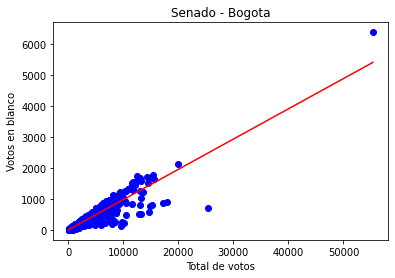

In [524]:
plt.scatter(VOTOS,BLANCO, c = 'b')
plt.plot(x_teorico, y_teorico, c = 'r')
xlabel('Total de votos')
ylabel('Votos en blanco')
title('Senado - Bogota')

In [525]:
modelo(2676288+66005,m_best,b_best)

268100.43695149204

In [526]:
182149+21301

203450

**Nulo**

In [527]:
x_obs = np.array(VOTOS)
y_obs = np.array(NULOS)

In [528]:
for i in range(1,n_iteraciones):
    m_prime = np.random.normal(m_walk[i-1],0.05)
    b_prime = np.random.normal(b_walk[i-1],0.05)

    l_now = loglikelihood(x_obs,y_obs, m_walk[i-1], b_walk[i-1])
    l_next = loglikelihood(x_obs,y_obs, m_prime, b_prime)
    gamma = np.min([1.0,np.exp(l_next-l_now)])
    # print(gamma)

    alpha = np.random.random()
    if alpha<gamma:
        m_walk[i] = m_prime
        b_walk[i] = b_prime
    else:
        m_walk[i] = m_walk[i-1]
        b_walk[i] = b_walk[i-1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


In [529]:
m_best = np.mean(m_walk)
m_error = np.std(m_walk)
print(m_best, m_error)

0.05291071649734497 0.0003643737552413422


In [530]:
b_best = np.mean(b_walk)
b_error = np.std(b_walk)
print(b_best, b_error)

3.3700756164673593 1.7428553711217791


In [531]:
x_teorico = np.linspace(x_obs.min(), x_obs.max(),1000)
y_teorico = modelo(x_teorico, m_best, b_best)

Text(0.5, 1.0, 'Senado - Bogota')

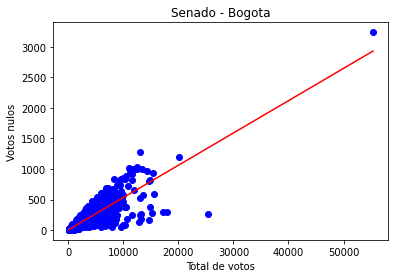

In [532]:
plt.scatter(VOTOS,NULOS, c = 'b')
plt.plot(x_teorico, y_teorico, c = 'r')
xlabel('Total de votos')
ylabel('Votos nulos')
title('Senado - Bogota')

In [533]:
modelo(2676288+66005,m_best,b_best)

145100.0575512701

In [534]:
71043+7633

78676

**No marcado**

In [535]:
x_obs = np.array(VOTOS)
y_obs = np.array(NO_MARCADOS)

In [536]:
for i in range(1,n_iteraciones):
    m_prime = np.random.normal(m_walk[i-1],0.05)
    b_prime = np.random.normal(b_walk[i-1],0.05)

    l_now = loglikelihood(x_obs,y_obs, m_walk[i-1], b_walk[i-1])
    l_next = loglikelihood(x_obs,y_obs, m_prime, b_prime)
    gamma = np.min([1.0,np.exp(l_next-l_now)])
    # print(gamma)

    alpha = np.random.random()
    if alpha<gamma:
        m_walk[i] = m_prime
        b_walk[i] = b_prime
    else:
        m_walk[i] = m_walk[i-1]
        b_walk[i] = b_walk[i-1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


In [537]:
m_best = np.mean(m_walk)
m_error = np.std(m_walk)
print(m_best, m_error)

0.017126892967916023 0.00029641114022560213


In [538]:
b_best = np.mean(b_walk)
b_error = np.std(b_walk)
print(b_best, b_error)

3.265105390419316 1.9719172611919538


In [539]:
x_teorico = np.linspace(x_obs.min(), x_obs.max(),1000)
y_teorico = modelo(x_teorico, m_best, b_best)

Text(0.5, 1.0, 'Senado - Bogota')

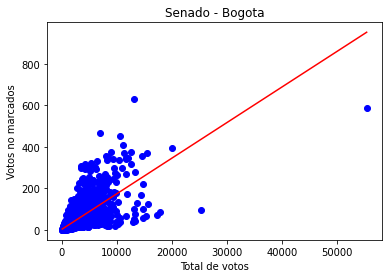

In [540]:
plt.scatter(VOTOS,NO_MARCADOS, c = 'b')
plt.plot(x_teorico, y_teorico, c = 'r')
xlabel('Total de votos')
ylabel('Votos no marcados')
title('Senado - Bogota')

In [541]:
modelo(2676288+66005,m_best,b_best)

46970.22380305576

In [542]:
31308+3879

35187

**Ajuste con numero de votos sin CORFERIAS**

In [ ]:
n = B[0]['npuesto']
b_votos = 0
n_votos = 0
A = []
for i in B:
    if n != 'PUESTO CENSO(FERIA EXPOSICION':
        if i['npuesto'] == n:
            n_votos += int(i['votos'])
            try:
                if i['candidato'] == 'VOTOS EN BLANCO':
                    b_votos += int(i['votos'])
            except Exception:
                pass
        else:
            A.append([n,n_votos,b_votos])
            n = i['npuesto']
            n_votos = int(i['votos'])
            b_votos = 0
shape(A)

(460, 3)

In [ ]:
A = np.array(A)
VOTOS = [int(x) for x in A[:,1]]
BLANCO = [int(x) for x in A[:,2]]

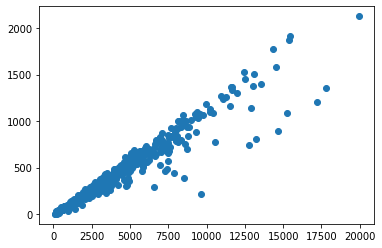

In [ ]:
scatter(VOTOS,BLANCO)

In [ ]:
x_obs = np.array(VOTOS)
y_obs = np.array(BLANCO)

In [ ]:
for i in range(1,n_iteraciones):
    m_prime = np.random.normal(m_walk[i-1],0.05)
    b_prime = np.random.normal(b_walk[i-1],0.05)

    l_now = loglikelihood(x_obs,y_obs, m_walk[i-1], b_walk[i-1])
    l_next = loglikelihood(x_obs,y_obs, m_prime, b_prime)
    gamma = np.min([1.0,np.exp(l_next-l_now)])
    # print(gamma)

    alpha = np.random.random()
    if alpha<gamma:
        m_walk[i] = m_prime
        b_walk[i] = b_prime
    else:
        m_walk[i] = m_walk[i-1]
        b_walk[i] = b_walk[i-1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


In [ ]:
m_best = np.mean(m_walk)
m_error = np.std(m_walk)
print(m_best, m_error)

0.10169439110082908 0.0005294499368370418


In [ ]:
b_best = np.mean(b_walk)
b_error = np.std(b_walk)
print(b_best, b_error)

2.3189928101617427 1.1229521446103257


In [ ]:
x_teorico = np.linspace(x_obs.min(), x_obs.max(),1000)
y_teorico = modelo(x_teorico, m_best, b_best)

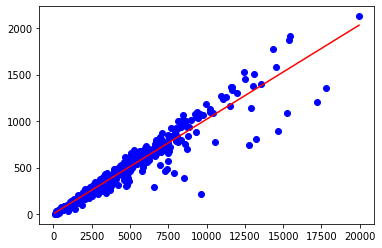

In [ ]:
plt.scatter(VOTOS,BLANCO, c = 'b')
plt.plot(x_teorico, y_teorico, c = 'r')

In [ ]:
modelo(2689646+41164+89165,m_best,b_best)

286777.9595373706

In [ ]:
203889+10964+20717

235570

# **Antioquia**

In [575]:
B1 = requests.get('https://www.datos.gov.co/resource/vkjr-c6fe.json?ndepto=ANTIOQUIA&$limit=500000&$order=npuesto ASC').text
B2 = requests.get('https://www.datos.gov.co/resource/vkjr-c6fe.json?ndepto=ANTIOQUIA&$limit=500000&$offset=500000&$order=npuesto ASC').text

In [576]:
B1 = json.loads(B1)
shape(B1)

(500000,)

In [577]:
B2 = json.loads(B2)
shape(B2)

(139419,)

In [578]:
B = B1 + B2
shape(B)

(639419,)

In [579]:
n = B[0]['npuesto']
b_votos = 0
n_votos = 0
A = []
for i in B:
    if i['npuesto'] == n:
        n_votos += int(i['votos'])
        try:
            if i['candidato'] == 'VOTOS EN BLANCO':
                b_votos += int(i['votos'])
        except Exception:
            pass
    else:
        A.append([n,n_votos,b_votos])
        n = i['npuesto']
        n_votos = int(i['votos'])
        b_votos = 0
shape(A)

(867, 3)

In [580]:
n = B[0]['npuesto']
nulos_votos = 0
n_votos = 0
A2 = []
for i in B:
    if i['npuesto'] == n:
        n_votos += int(i['votos'])
        try:
            if i['candidato'] == 'VOTOS NULOS':
                nulos_votos += int(i['votos'])
        except Exception:
            pass
    else:
        A2.append([n,n_votos,nulos_votos])
        n = i['npuesto']
        n_votos = int(i['votos'])
        nulos_votos = 0
shape(A)

(867, 3)

In [581]:
n = B[0]['npuesto']
nmarcados_votos = 0
n_votos = 0
A3 = []
for i in B:
    if i['npuesto'] == n:
        n_votos += int(i['votos'])
        try:
            if i['candidato'] == 'VOTOS NO MARCADOS':
                nmarcados_votos += int(i['votos'])
        except Exception:
            pass
    else:
        A3.append([n,n_votos,nmarcados_votos])
        n = i['npuesto']
        n_votos = int(i['votos'])
        nmarcados_votos = 0
shape(A)

(867, 3)

In [582]:
A = np.array(A)
A2 = np.array(A2)
A3 = np.array(A3)
VOTOS = [int(x) for x in A[:,1]]
BLANCO = [int(x) for x in A[:,2]]
NULOS = [int(x) for x in A2[:,2]]
NO_MARCADOS = [int(x) for x in A3[:,2]]

Text(0.5, 1.0, 'Camara - Antioquia')

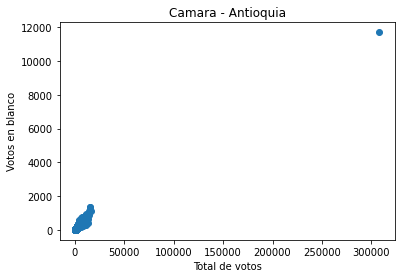

In [583]:
scatter(VOTOS,BLANCO)
xlabel('Total de votos')
ylabel('Votos en blanco')
title('Camara - Antioquia')

Text(0.5, 1.0, 'Camara - Antioquia')

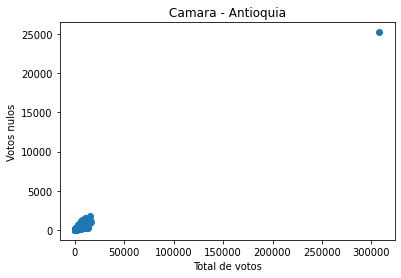

In [584]:
scatter(VOTOS,NULOS)
xlabel('Total de votos')
ylabel('Votos nulos')
title('Camara - Antioquia')

Text(0.5, 1.0, 'Camara - Antioquia')

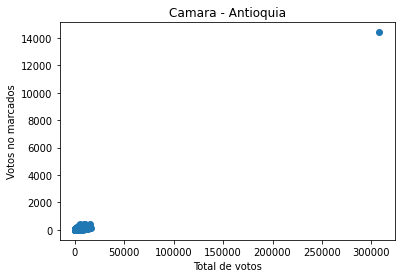

In [585]:
scatter(VOTOS,NO_MARCADOS)
xlabel('Total de votos')
ylabel('Votos no marcados')
title('Camara - Antioquia')

**Blanco**

In [586]:
x_obs = np.array(VOTOS)
y_obs = np.array(BLANCO)

In [587]:
for i in range(1,n_iteraciones):
    m_prime = np.random.normal(m_walk[i-1],0.05)
    b_prime = np.random.normal(b_walk[i-1],0.05)

    l_now = loglikelihood(x_obs,y_obs, m_walk[i-1], b_walk[i-1])
    l_next = loglikelihood(x_obs,y_obs, m_prime, b_prime)
    gamma = np.min([1.0,np.exp(l_next-l_now)])
    # print(gamma)

    alpha = np.random.random()
    if alpha<gamma:
        m_walk[i] = m_prime
        b_walk[i] = b_prime
    else:
        m_walk[i] = m_walk[i-1]
        b_walk[i] = b_walk[i-1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


In [588]:
m_best = np.mean(m_walk)
m_error = np.std(m_walk)
print(m_best, m_error)

0.04110080028817132 0.00038247516875662636


In [589]:
b_best = np.mean(b_walk)
b_error = np.std(b_walk)
print(b_best, b_error)

4.519815240112628 2.300468554951475


In [590]:
x_teorico = np.linspace(x_obs.min(), x_obs.max(),1000)
y_teorico = modelo(x_teorico, m_best, b_best)

Text(0.5, 1.0, 'Camara - Antioquia')

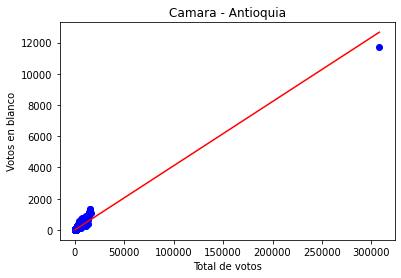

In [591]:
plt.scatter(VOTOS,BLANCO, c = 'b')
plt.plot(x_teorico, y_teorico, c = 'r')
xlabel('Total de votos')
ylabel('Votos en blanco')
title('Camara - Antioquia')

In [592]:
modelo(2133780+23390+69361,m_best,b_best)

91516.72578166249

In [593]:
163611+6821+17262

187694

**Nulo**

In [594]:
x_obs = np.array(VOTOS)
y_obs = np.array(NULOS)

In [595]:
for i in range(1,n_iteraciones):
    m_prime = np.random.normal(m_walk[i-1],0.05)
    b_prime = np.random.normal(b_walk[i-1],0.05)

    l_now = loglikelihood(x_obs,y_obs, m_walk[i-1], b_walk[i-1])
    l_next = loglikelihood(x_obs,y_obs, m_prime, b_prime)
    gamma = np.min([1.0,np.exp(l_next-l_now)])
    # print(gamma)

    alpha = np.random.random()
    if alpha<gamma:
        m_walk[i] = m_prime
        b_walk[i] = b_prime
    else:
        m_walk[i] = m_walk[i-1]
        b_walk[i] = b_walk[i-1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


In [596]:
m_best = np.mean(m_walk)
m_error = np.std(m_walk)
print(m_best, m_error)

0.08281173250265922 0.00040258134377880127


In [597]:
b_best = np.mean(b_walk)
b_error = np.std(b_walk)
print(b_best, b_error)

3.0024361553282763 1.931569945527046


In [598]:
x_teorico = np.linspace(x_obs.min(), x_obs.max(),1000)
y_teorico = modelo(x_teorico, m_best, b_best)

Text(0.5, 1.0, 'Camara - Antioquia')

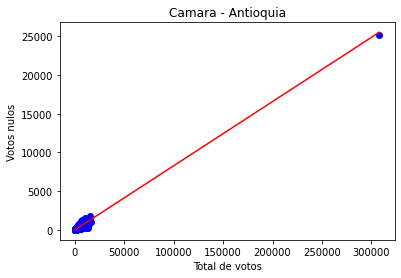

In [599]:
plt.scatter(VOTOS,NULOS, c = 'b')
plt.plot(x_teorico, y_teorico, c = 'r')
xlabel('Total de votos')
ylabel('Votos nulos')
title('Camara - Antioquia')

In [600]:
modelo(2133780+23390+69361,m_best,b_best)

184385.89201703368

In [601]:
95764+3365+9220

108349

**No marcado**

In [602]:
x_obs = np.array(VOTOS)
y_obs = np.array(NO_MARCADOS)

In [603]:
for i in range(1,n_iteraciones):
    m_prime = np.random.normal(m_walk[i-1],0.05)
    b_prime = np.random.normal(b_walk[i-1],0.05)

    l_now = loglikelihood(x_obs,y_obs, m_walk[i-1], b_walk[i-1])
    l_next = loglikelihood(x_obs,y_obs, m_prime, b_prime)
    gamma = np.min([1.0,np.exp(l_next-l_now)])
    # print(gamma)

    alpha = np.random.random()
    if alpha<gamma:
        m_walk[i] = m_prime
        b_walk[i] = b_prime
    else:
        m_walk[i] = m_walk[i-1]
        b_walk[i] = b_walk[i-1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


In [604]:
m_best = np.mean(m_walk)
m_error = np.std(m_walk)
print(m_best, m_error)

0.04480163490958707 0.000301286190387703


In [605]:
b_best = np.mean(b_walk)
b_error = np.std(b_walk)
print(b_best, b_error)

-2.4180467324044033 1.3742573027915448


In [606]:
x_teorico = np.linspace(x_obs.min(), x_obs.max(),1000)
y_teorico = modelo(x_teorico, m_best, b_best)

Text(0.5, 1.0, 'Camara - Antioquia')

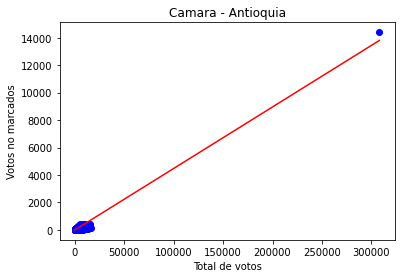

In [608]:
plt.scatter(VOTOS,NO_MARCADOS, c = 'b')
plt.plot(x_teorico, y_teorico, c = 'r')
xlabel('Total de votos')
ylabel('Votos no marcados')
title('Camara - Antioquia')

In [609]:
modelo(2133780+23390+69361,m_best,b_best)

99749.81093014541

In [610]:
56595+2772+8459

67826

In [611]:
V1 = requests.get('https://www.datos.gov.co/resource/75f2-fe2s.json?ndepto=ANTIOQUIA&$limit=500000&$order=npuesto ASC').text
V2 = requests.get('https://www.datos.gov.co/resource/75f2-fe2s.json?ndepto=ANTIOQUIA&$limit=500000&$offset=500000&$order=npuesto ASC').text

In [612]:
V1 = json.loads(V1)
shape(V1)

(500000,)

In [613]:
V2 = json.loads(V2)
shape(V2)

(145984,)

In [614]:
V = V1 + V2
shape(V)

(645984,)

In [615]:
n = V[0]['npuesto']
b_votos = 0
n_votos = 0
A = []
for i in V:
    if i['npuesto'] == n:
        n_votos += int(i['votos'])
        try:
            if i['candidato'] == 'VOTOS EN BLANCO':
                b_votos += int(i['votos'])
        except Exception:
            pass
    else:
        A.append([n,n_votos,b_votos])
        n = i['npuesto']
        n_votos = int(i['votos'])
        b_votos = 0
shape(A)

(867, 3)

In [616]:
n = V[0]['npuesto']
nulos_votos = 0
n_votos = 0
A2 = []
for i in V:
    if i['npuesto'] == n:
        n_votos += int(i['votos'])
        try:
            if i['candidato'] == 'VOTOS NULOS':
                nulos_votos += int(i['votos'])
        except Exception:
            pass
    else:
        A2.append([n,n_votos,nulos_votos])
        n = i['npuesto']
        n_votos = int(i['votos'])
        nulos_votos = 0
shape(A)

(867, 3)

In [617]:
n = V[0]['npuesto']
nmarcados_votos = 0
n_votos = 0
A3 = []
for i in V:
    if i['npuesto'] == n:
        n_votos += int(i['votos'])
        try:
            if i['candidato'] == 'VOTOS NO MARCADOS':
                nmarcados_votos += int(i['votos'])
        except Exception:
            pass
    else:
        A3.append([n,n_votos,nmarcados_votos])
        n = i['npuesto']
        n_votos = int(i['votos'])
        nmarcados_votos = 0
shape(A)

(867, 3)

In [618]:
A = np.array(A)
A2 = np.array(A2)
A3 = np.array(A3)
VOTOS = [int(x) for x in A[:,1]]
BLANCO = [int(x) for x in A[:,2]]
NULOS = [int(x) for x in A2[:,2]]
NO_MARCADOS = [int(x) for x in A3[:,2]]

Text(0.5, 1.0, 'Senado - Antioquia')

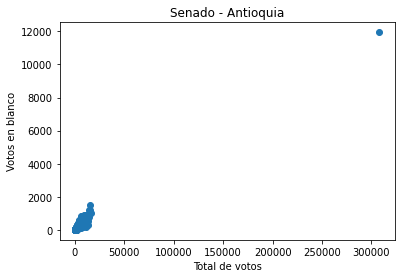

In [619]:
scatter(VOTOS,BLANCO)
xlabel('Total de votos')
ylabel('Votos en blanco')
title('Senado - Antioquia')

Text(0.5, 1.0, 'Senado - Antioquia')

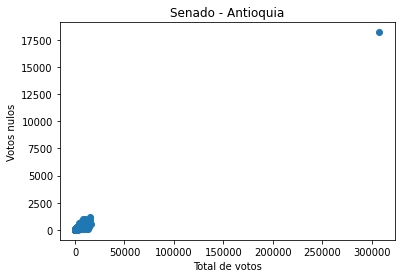

In [621]:
scatter(VOTOS,NULOS)
xlabel('Total de votos')
ylabel('Votos nulos')
title('Senado - Antioquia')

Text(0.5, 1.0, 'Senado - Antioquia')

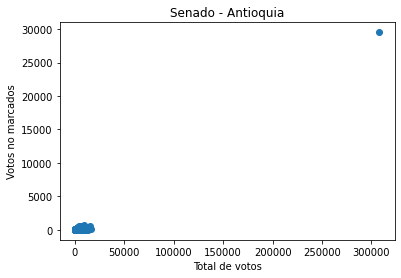

In [622]:
scatter(VOTOS,NO_MARCADOS)
xlabel('Total de votos')
ylabel('Votos no marcados')
title('Senado - Antioquia')

**Blanco**

In [623]:
x_obs = np.array(VOTOS)
y_obs = np.array(BLANCO)

In [624]:
for i in range(1,n_iteraciones):
    m_prime = np.random.normal(m_walk[i-1],0.05)
    b_prime = np.random.normal(b_walk[i-1],0.05)

    l_now = loglikelihood(x_obs,y_obs, m_walk[i-1], b_walk[i-1])
    l_next = loglikelihood(x_obs,y_obs, m_prime, b_prime)
    gamma = np.min([1.0,np.exp(l_next-l_now)])
    # print(gamma)

    alpha = np.random.random()
    if alpha<gamma:
        m_walk[i] = m_prime
        b_walk[i] = b_prime
    else:
        m_walk[i] = m_walk[i-1]
        b_walk[i] = b_walk[i-1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


In [625]:
m_best = np.mean(m_walk)
m_error = np.std(m_walk)
print(m_best, m_error)

0.042100213865079984 0.0003229615923753992


In [626]:
b_best = np.mean(b_walk)
b_error = np.std(b_walk)
print(b_best, b_error)

4.640458145845086 2.461318430463293


In [627]:
x_teorico = np.linspace(x_obs.min(), x_obs.max(),1000)
y_teorico = modelo(x_teorico, m_best, b_best)

Text(0.5, 1.0, 'Senado - Antioquia')

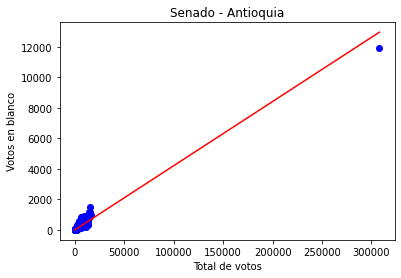

In [628]:
plt.scatter(VOTOS,BLANCO, c = 'b')
plt.plot(x_teorico, y_teorico, c = 'r')
xlabel('Total de votos')
ylabel('Votos en blanco')
title('Senado - Antioquia')

In [629]:
modelo(2179147+40091,m_best,b_best)

93435.03487565822

In [630]:
159773+14819

174592

**Nulo**

In [631]:
x_obs = np.array(VOTOS)
y_obs = np.array(NULOS)

In [632]:
for i in range(1,n_iteraciones):
    m_prime = np.random.normal(m_walk[i-1],0.05)
    b_prime = np.random.normal(b_walk[i-1],0.05)

    l_now = loglikelihood(x_obs,y_obs, m_walk[i-1], b_walk[i-1])
    l_next = loglikelihood(x_obs,y_obs, m_prime, b_prime)
    gamma = np.min([1.0,np.exp(l_next-l_now)])
    # print(gamma)

    alpha = np.random.random()
    if alpha<gamma:
        m_walk[i] = m_prime
        b_walk[i] = b_prime
    else:
        m_walk[i] = m_walk[i-1]
        b_walk[i] = b_walk[i-1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


In [633]:
m_best = np.mean(m_walk)
m_error = np.std(m_walk)
print(m_best, m_error)

0.05956533053321892 0.00021132429435412523


In [634]:
b_best = np.mean(b_walk)
b_error = np.std(b_walk)
print(b_best, b_error)

2.124414171900211 1.247960316245151


In [635]:
x_teorico = np.linspace(x_obs.min(), x_obs.max(),1000)
y_teorico = modelo(x_teorico, m_best, b_best)

Text(0.5, 1.0, 'Senado - Antioquia')

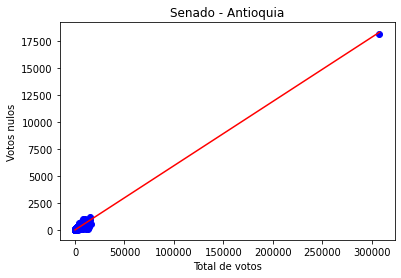

In [636]:
plt.scatter(VOTOS,NULOS, c = 'b')
plt.plot(x_teorico, y_teorico, c = 'r')
xlabel('Total de votos')
ylabel('Votos nulos')
title('Senado - Antioquia')

In [637]:
modelo(2179147+40091,m_best,b_best)

132191.7694160516

In [638]:
82866+7946

90812

**No marcado**

In [639]:
x_obs = np.array(VOTOS)
y_obs = np.array(NO_MARCADOS)

In [640]:
for i in range(1,n_iteraciones):
    m_prime = np.random.normal(m_walk[i-1],0.05)
    b_prime = np.random.normal(b_walk[i-1],0.05)

    l_now = loglikelihood(x_obs,y_obs, m_walk[i-1], b_walk[i-1])
    l_next = loglikelihood(x_obs,y_obs, m_prime, b_prime)
    gamma = np.min([1.0,np.exp(l_next-l_now)])
    # print(gamma)

    alpha = np.random.random()
    if alpha<gamma:
        m_walk[i] = m_prime
        b_walk[i] = b_prime
    else:
        m_walk[i] = m_walk[i-1]
        b_walk[i] = b_walk[i-1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


In [641]:
m_best = np.mean(m_walk)
m_error = np.std(m_walk)
print(m_best, m_error)

0.0907644229036966 0.0005873924400568122


In [642]:
b_best = np.mean(b_walk)
b_error = np.std(b_walk)
print(b_best, b_error)

-4.133001998780201 2.6524031812889097


In [643]:
x_teorico = np.linspace(x_obs.min(), x_obs.max(),1000)
y_teorico = modelo(x_teorico, m_best, b_best)

Text(0.5, 1.0, 'Senado - Antioquia')

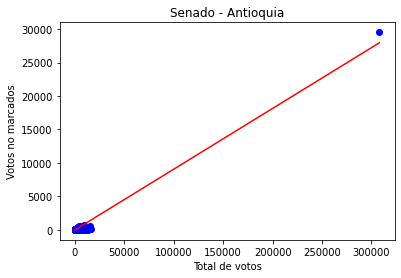

In [644]:
plt.scatter(VOTOS,NO_MARCADOS, c = 'b')
plt.plot(x_teorico, y_teorico, c = 'r')
xlabel('Total de votos')
ylabel('Votos no marcados')
title('Senado - Antioquia')

In [645]:
modelo(2179147+40091,m_best,b_best)

201423.72335395505

In [646]:
71451+7783

79234

# **Atlantico**

In [647]:
B1 = requests.get('https://www.datos.gov.co/resource/vkjr-c6fe.json?ndepto=ATLANTICO&$limit=500000&$order=npuesto ASC').text
B2 = requests.get('https://www.datos.gov.co/resource/vkjr-c6fe.json?ndepto=ATLANTICO&$limit=500000&$offset=500000&$order=npuesto ASC').text

In [648]:
B1 = json.loads(B1)
shape(B1)

(221135,)

In [649]:
B2 = json.loads(B2)
shape(B2)

(0,)

In [650]:
B = B1 + B2
shape(B)

(221135,)

In [651]:
n = B[0]['npuesto']
b_votos = 0
n_votos = 0
A = []
for i in B:
    if i['npuesto'] == n:
        n_votos += int(i['votos'])
        try:
            if i['candidato'] == 'VOTOS EN BLANCO':
                b_votos += int(i['votos'])
        except Exception:
            pass
    else:
        A.append([n,n_votos,b_votos])
        n = i['npuesto']
        n_votos = int(i['votos'])
        b_votos = 0
shape(A)

(256, 3)

In [652]:
n = B[0]['npuesto']
nulos_votos = 0
n_votos = 0
A2 = []
for i in B:
    if i['npuesto'] == n:
        n_votos += int(i['votos'])
        try:
            if i['candidato'] == 'VOTOS NULOS':
                nulos_votos += int(i['votos'])
        except Exception:
            pass
    else:
        A2.append([n,n_votos,nulos_votos])
        n = i['npuesto']
        n_votos = int(i['votos'])
        nulos_votos = 0
shape(A)

(256, 3)

In [653]:
n = B[0]['npuesto']
nmarcados_votos = 0
n_votos = 0
A3 = []
for i in B:
    if i['npuesto'] == n:
        n_votos += int(i['votos'])
        try:
            if i['candidato'] == 'VOTOS NO MARCADOS':
                nmarcados_votos += int(i['votos'])
        except Exception:
            pass
    else:
        A3.append([n,n_votos,nmarcados_votos])
        n = i['npuesto']
        n_votos = int(i['votos'])
        nmarcados_votos = 0
shape(A)

(256, 3)

In [654]:
A = np.array(A)
A2 = np.array(A2)
A3 = np.array(A3)
VOTOS = [int(x) for x in A[:,1]]
BLANCO = [int(x) for x in A[:,2]]
NULOS = [int(x) for x in A2[:,2]]
NO_MARCADOS = [int(x) for x in A3[:,2]]

Text(0.5, 1.0, 'Camara - Atlantico')

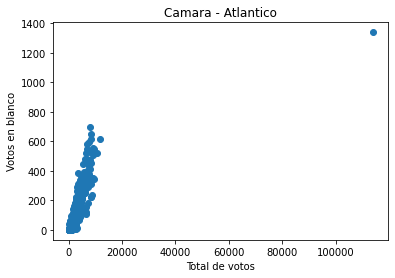

In [655]:
scatter(VOTOS,BLANCO)
xlabel('Total de votos')
ylabel('Votos en blanco')
title('Camara - Atlantico')

Text(0.5, 1.0, 'Camara - Atlantico')

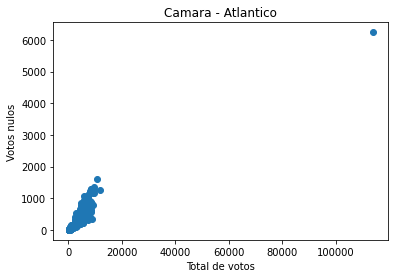

In [656]:
scatter(VOTOS,NULOS)
xlabel('Total de votos')
ylabel('Votos nulos')
title('Camara - Atlantico')

Text(0.5, 1.0, 'Camara - Atlantico')

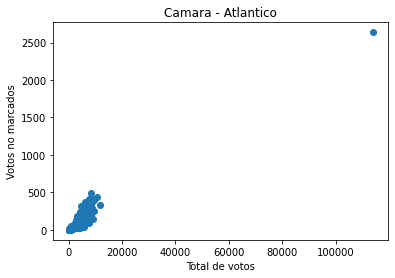

In [657]:
scatter(VOTOS,NO_MARCADOS)
xlabel('Total de votos')
ylabel('Votos no marcados')
title('Camara - Atlantico')

**Blanco**

In [658]:
x_obs = np.array(VOTOS)
y_obs = np.array(BLANCO)

In [659]:
for i in range(1,n_iteraciones):
    m_prime = np.random.normal(m_walk[i-1],0.05)
    b_prime = np.random.normal(b_walk[i-1],0.05)

    l_now = loglikelihood(x_obs,y_obs, m_walk[i-1], b_walk[i-1])
    l_next = loglikelihood(x_obs,y_obs, m_prime, b_prime)
    gamma = np.min([1.0,np.exp(l_next-l_now)])
    # print(gamma)

    alpha = np.random.random()
    if alpha<gamma:
        m_walk[i] = m_prime
        b_walk[i] = b_prime
    else:
        m_walk[i] = m_walk[i-1]
        b_walk[i] = b_walk[i-1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


In [660]:
m_best = np.mean(m_walk)
m_error = np.std(m_walk)
print(m_best, m_error)

0.02351471431220706 0.0003524052149775346


In [661]:
b_best = np.mean(b_walk)
b_error = np.std(b_walk)
print(b_best, b_error)

6.8213213942262705 3.8556096517316543


In [662]:
x_teorico = np.linspace(x_obs.min(), x_obs.max(),1000)
y_teorico = modelo(x_teorico, m_best, b_best)

Text(0.5, 1.0, 'Camara - Atlantico')

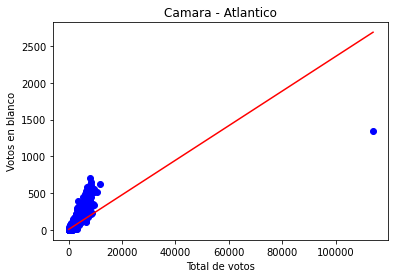

In [663]:
plt.scatter(VOTOS,BLANCO, c = 'b')
plt.plot(x_teorico, y_teorico, c = 'r')
xlabel('Total de votos')
ylabel('Votos en blanco')
title('Camara - Atlantico')

In [666]:
modelo(981961+12054+91993,m_best,b_best)

25543.98918216559

In [667]:
43942+3501+10398

57841

**Nulo**

In [668]:
x_obs = np.array(VOTOS)
y_obs = np.array(NULOS)

In [669]:
for i in range(1,n_iteraciones):
    m_prime = np.random.normal(m_walk[i-1],0.05)
    b_prime = np.random.normal(b_walk[i-1],0.05)

    l_now = loglikelihood(x_obs,y_obs, m_walk[i-1], b_walk[i-1])
    l_next = loglikelihood(x_obs,y_obs, m_prime, b_prime)
    gamma = np.min([1.0,np.exp(l_next-l_now)])
    # print(gamma)

    alpha = np.random.random()
    if alpha<gamma:
        m_walk[i] = m_prime
        b_walk[i] = b_prime
    else:
        m_walk[i] = m_walk[i-1]
        b_walk[i] = b_walk[i-1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


In [670]:
m_best = np.mean(m_walk)
m_error = np.std(m_walk)
print(m_best, m_error)

0.06867906635985747 0.0006618765500665794


In [671]:
b_best = np.mean(b_walk)
b_error = np.std(b_walk)
print(b_best, b_error)

6.804896184309619 3.473194216232764


In [672]:
x_teorico = np.linspace(x_obs.min(), x_obs.max(),1000)
y_teorico = modelo(x_teorico, m_best, b_best)

Text(0.5, 1.0, 'Camara - Atlantico')

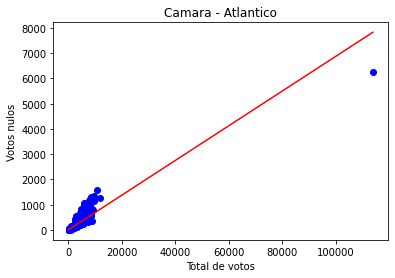

In [673]:
plt.scatter(VOTOS,NULOS, c = 'b')
plt.plot(x_teorico, y_teorico, c = 'r')
xlabel('Total de votos')
ylabel('Votos nulos')
title('Camara - Atlantico')

In [675]:
modelo(981961+12054+91993,m_best,b_best)

74592.82039552041

In [676]:
39393+1794+8169

49356

**No marcado**

In [677]:
x_obs = np.array(VOTOS)
y_obs = np.array(NO_MARCADOS)

In [678]:
for i in range(1,n_iteraciones):
    m_prime = np.random.normal(m_walk[i-1],0.05)
    b_prime = np.random.normal(b_walk[i-1],0.05)

    l_now = loglikelihood(x_obs,y_obs, m_walk[i-1], b_walk[i-1])
    l_next = loglikelihood(x_obs,y_obs, m_prime, b_prime)
    gamma = np.min([1.0,np.exp(l_next-l_now)])
    # print(gamma)

    alpha = np.random.random()
    if alpha<gamma:
        m_walk[i] = m_prime
        b_walk[i] = b_prime
    else:
        m_walk[i] = m_walk[i-1]
        b_walk[i] = b_walk[i-1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


In [679]:
m_best = np.mean(m_walk)
m_error = np.std(m_walk)
print(m_best, m_error)

0.02591679110434484 0.00024740479817391054


In [680]:
b_best = np.mean(b_walk)
b_error = np.std(b_walk)
print(b_best, b_error)

3.432176385272181 1.9318433749664958


In [681]:
x_teorico = np.linspace(x_obs.min(), x_obs.max(),1000)
y_teorico = modelo(x_teorico, m_best, b_best)

Text(0.5, 1.0, 'Camara - Atlantico')

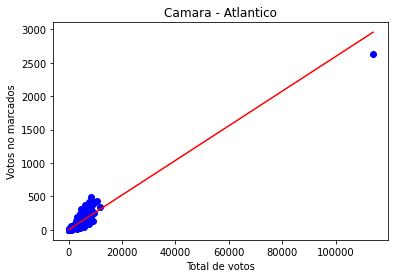

In [682]:
plt.scatter(VOTOS,NO_MARCADOS, c = 'b')
plt.plot(x_teorico, y_teorico, c = 'r')
xlabel('Total de votos')
ylabel('Votos no marcados')
title('Camara - Atlantico')

In [683]:
modelo(981961+12054+91993,m_best,b_best)

28149.274650032603

In [863]:
27510+2439+9116

39065

In [685]:
V1 = requests.get('https://www.datos.gov.co/resource/75f2-fe2s.json?ndepto=ANTIOQUIA&$limit=500000&$order=npuesto ASC').text
V2 = requests.get('https://www.datos.gov.co/resource/75f2-fe2s.json?ndepto=ANTIOQUIA&$limit=500000&$offset=500000&$order=npuesto ASC').text

In [686]:
V1 = json.loads(V1)
shape(V1)

(500000,)

In [687]:
V2 = json.loads(V2)
shape(V2)

(145984,)

In [688]:
V = V1 + V2
shape(V)

(645984,)

In [689]:
n = V[0]['npuesto']
b_votos = 0
n_votos = 0
A = []
for i in V:
    if i['npuesto'] == n:
        n_votos += int(i['votos'])
        try:
            if i['candidato'] == 'VOTOS EN BLANCO':
                b_votos += int(i['votos'])
        except Exception:
            pass
    else:
        A.append([n,n_votos,b_votos])
        n = i['npuesto']
        n_votos = int(i['votos'])
        b_votos = 0
shape(A)

(867, 3)

In [690]:
n = V[0]['npuesto']
nulos_votos = 0
n_votos = 0
A2 = []
for i in V:
    if i['npuesto'] == n:
        n_votos += int(i['votos'])
        try:
            if i['candidato'] == 'VOTOS NULOS':
                nulos_votos += int(i['votos'])
        except Exception:
            pass
    else:
        A2.append([n,n_votos,nulos_votos])
        n = i['npuesto']
        n_votos = int(i['votos'])
        nulos_votos = 0
shape(A)

(867, 3)

In [691]:
n = V[0]['npuesto']
nmarcados_votos = 0
n_votos = 0
A3 = []
for i in V:
    if i['npuesto'] == n:
        n_votos += int(i['votos'])
        try:
            if i['candidato'] == 'VOTOS NO MARCADOS':
                nmarcados_votos += int(i['votos'])
        except Exception:
            pass
    else:
        A3.append([n,n_votos,nmarcados_votos])
        n = i['npuesto']
        n_votos = int(i['votos'])
        nmarcados_votos = 0
shape(A)

(867, 3)

In [692]:
A = np.array(A)
A2 = np.array(A2)
A3 = np.array(A3)
VOTOS = [int(x) for x in A[:,1]]
BLANCO = [int(x) for x in A[:,2]]
NULOS = [int(x) for x in A2[:,2]]
NO_MARCADOS = [int(x) for x in A3[:,2]]

Text(0.5, 1.0, 'Senado - Atlantico')

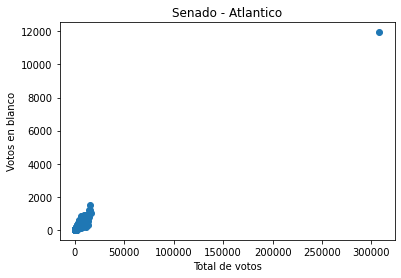

In [693]:
scatter(VOTOS,BLANCO)
xlabel('Total de votos')
ylabel('Votos en blanco')
title('Senado - Atlantico')

Text(0.5, 1.0, 'Senado - Atlantico')

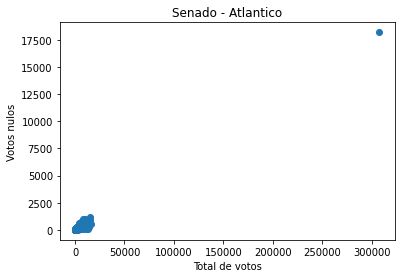

In [694]:
scatter(VOTOS,NULOS)
xlabel('Total de votos')
ylabel('Votos nulos')
title('Senado - Atlantico')

Text(0.5, 1.0, 'Senado - Atlantico')

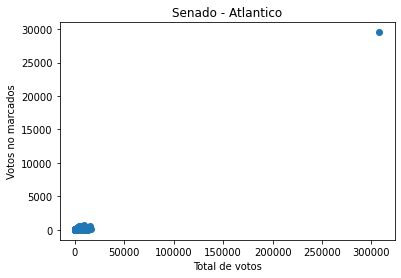

In [695]:
scatter(VOTOS,NO_MARCADOS)
xlabel('Total de votos')
ylabel('Votos no marcados')
title('Senado - Atlantico')

**Blanco**

In [696]:
x_obs = np.array(VOTOS)
y_obs = np.array(BLANCO)

In [697]:
for i in range(1,n_iteraciones):
    m_prime = np.random.normal(m_walk[i-1],0.05)
    b_prime = np.random.normal(b_walk[i-1],0.05)

    l_now = loglikelihood(x_obs,y_obs, m_walk[i-1], b_walk[i-1])
    l_next = loglikelihood(x_obs,y_obs, m_prime, b_prime)
    gamma = np.min([1.0,np.exp(l_next-l_now)])
    # print(gamma)

    alpha = np.random.random()
    if alpha<gamma:
        m_walk[i] = m_prime
        b_walk[i] = b_prime
    else:
        m_walk[i] = m_walk[i-1]
        b_walk[i] = b_walk[i-1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


In [698]:
m_best = np.mean(m_walk)
m_error = np.std(m_walk)
print(m_best, m_error)

0.0421166791295352 0.0003235949521879357


In [699]:
b_best = np.mean(b_walk)
b_error = np.std(b_walk)
print(b_best, b_error)

4.294483055308864 2.54562564693951


In [700]:
x_teorico = np.linspace(x_obs.min(), x_obs.max(),1000)
y_teorico = modelo(x_teorico, m_best, b_best)

Text(0.5, 1.0, 'Senado - Atlantico')

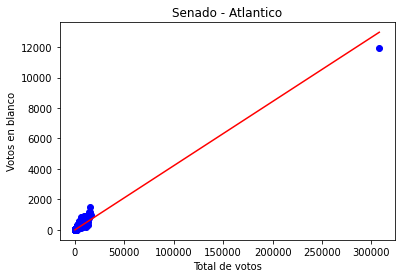

In [701]:
plt.scatter(VOTOS,BLANCO, c = 'b')
plt.plot(x_teorico, y_teorico, c = 'r')
xlabel('Total de votos')
ylabel('Votos en blanco')
title('Senado - Atlantico')

In [702]:
modelo(1041804+26525,m_best,b_best)

44998.76418083252

In [703]:
40080+7587

47667

**Nulo**

In [704]:
x_obs = np.array(VOTOS)
y_obs = np.array(NULOS)

In [705]:
for i in range(1,n_iteraciones):
    m_prime = np.random.normal(m_walk[i-1],0.05)
    b_prime = np.random.normal(b_walk[i-1],0.05)

    l_now = loglikelihood(x_obs,y_obs, m_walk[i-1], b_walk[i-1])
    l_next = loglikelihood(x_obs,y_obs, m_prime, b_prime)
    gamma = np.min([1.0,np.exp(l_next-l_now)])
    # print(gamma)

    alpha = np.random.random()
    if alpha<gamma:
        m_walk[i] = m_prime
        b_walk[i] = b_prime
    else:
        m_walk[i] = m_walk[i-1]
        b_walk[i] = b_walk[i-1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


In [706]:
m_best = np.mean(m_walk)
m_error = np.std(m_walk)
print(m_best, m_error)

0.0595469263152041 0.00037446341690819895


In [707]:
b_best = np.mean(b_walk)
b_error = np.std(b_walk)
print(b_best, b_error)

2.2224020216347835 1.1385479989038934


In [708]:
x_teorico = np.linspace(x_obs.min(), x_obs.max(),1000)
y_teorico = modelo(x_teorico, m_best, b_best)

Text(0.5, 1.0, 'Senado - Atlantico')

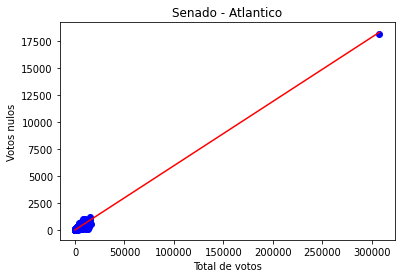

In [709]:
plt.scatter(VOTOS,NULOS, c = 'b')
plt.plot(x_teorico, y_teorico, c = 'r')
xlabel('Total de votos')
ylabel('Votos nulos')
title('Senado - Atlantico')

In [710]:
modelo(1041804+26525,m_best,b_best)

63617.93064541732

In [864]:
36041+6331

42372

**No marcado**

In [712]:
x_obs = np.array(VOTOS)
y_obs = np.array(NO_MARCADOS)

In [713]:
for i in range(1,n_iteraciones):
    m_prime = np.random.normal(m_walk[i-1],0.05)
    b_prime = np.random.normal(b_walk[i-1],0.05)

    l_now = loglikelihood(x_obs,y_obs, m_walk[i-1], b_walk[i-1])
    l_next = loglikelihood(x_obs,y_obs, m_prime, b_prime)
    gamma = np.min([1.0,np.exp(l_next-l_now)])
    # print(gamma)

    alpha = np.random.random()
    if alpha<gamma:
        m_walk[i] = m_prime
        b_walk[i] = b_prime
    else:
        m_walk[i] = m_walk[i-1]
        b_walk[i] = b_walk[i-1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


In [714]:
m_best = np.mean(m_walk)
m_error = np.std(m_walk)
print(m_best, m_error)

0.09078404661918404 0.000445423572404569


In [715]:
b_best = np.mean(b_walk)
b_error = np.std(b_walk)
print(b_best, b_error)

-4.635165461565123 2.6974082948365066


In [716]:
x_teorico = np.linspace(x_obs.min(), x_obs.max(),1000)
y_teorico = modelo(x_teorico, m_best, b_best)

Text(0.5, 1.0, 'Senado - Atlantico')

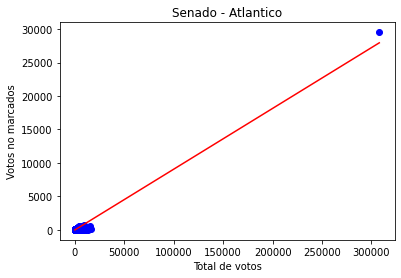

In [717]:
plt.scatter(VOTOS,NO_MARCADOS, c = 'b')
plt.plot(x_teorico, y_teorico, c = 'r')
xlabel('Total de votos')
ylabel('Votos no marcados')
title('Senado - Atlantico')

In [718]:
modelo(1041804+26525,m_best,b_best)

96982.5945751647

In [719]:
34454+7133

41587

# **Valle**

In [720]:
B1 = requests.get('https://www.datos.gov.co/resource/vkjr-c6fe.json?ndepto=VALLE&$limit=500000&$order=npuesto ASC').text
B2 = requests.get('https://www.datos.gov.co/resource/vkjr-c6fe.json?ndepto=VALLE&$limit=500000&$offset=500000&$order=npuesto ASC').text

In [721]:
B1 = json.loads(B1)
shape(B1)

(493227,)

In [722]:
B2 = json.loads(B2)
shape(B2)

(0,)

In [723]:
B = B1 + B2
shape(B)

(493227,)

In [724]:
n = B[0]['npuesto']
b_votos = 0
n_votos = 0
A = []
for i in B:
    if i['npuesto'] == n:
        n_votos += int(i['votos'])
        try:
            if i['candidato'] == 'VOTOS EN BLANCO':
                b_votos += int(i['votos'])
        except Exception:
            pass
    else:
        A.append([n,n_votos,b_votos])
        n = i['npuesto']
        n_votos = int(i['votos'])
        b_votos = 0
shape(A)

(906, 3)

In [725]:
n = B[0]['npuesto']
nulos_votos = 0
n_votos = 0
A2 = []
for i in B:
    if i['npuesto'] == n:
        n_votos += int(i['votos'])
        try:
            if i['candidato'] == 'VOTOS NULOS':
                nulos_votos += int(i['votos'])
        except Exception:
            pass
    else:
        A2.append([n,n_votos,nulos_votos])
        n = i['npuesto']
        n_votos = int(i['votos'])
        nulos_votos = 0
shape(A)

(906, 3)

In [726]:
n = B[0]['npuesto']
nmarcados_votos = 0
n_votos = 0
A3 = []
for i in B:
    if i['npuesto'] == n:
        n_votos += int(i['votos'])
        try:
            if i['candidato'] == 'VOTOS NO MARCADOS':
                nmarcados_votos += int(i['votos'])
        except Exception:
            pass
    else:
        A3.append([n,n_votos,nmarcados_votos])
        n = i['npuesto']
        n_votos = int(i['votos'])
        nmarcados_votos = 0
shape(A)

(906, 3)

In [727]:
A = np.array(A)
A2 = np.array(A2)
A3 = np.array(A3)
VOTOS = [int(x) for x in A[:,1]]
BLANCO = [int(x) for x in A[:,2]]
NULOS = [int(x) for x in A2[:,2]]
NO_MARCADOS = [int(x) for x in A3[:,2]]

Text(0.5, 1.0, 'Camara - Valle')

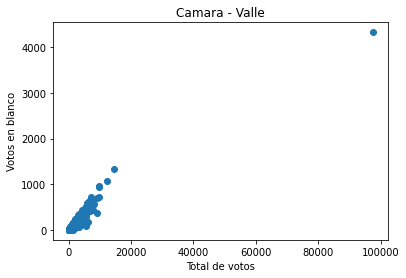

In [728]:
scatter(VOTOS,BLANCO)
xlabel('Total de votos')
ylabel('Votos en blanco')
title('Camara - Valle')

Text(0.5, 1.0, 'Camara - Valle')

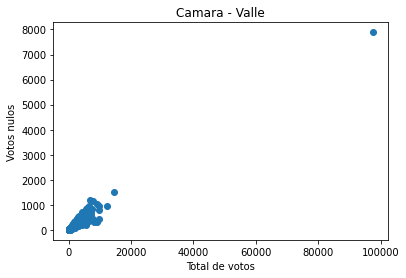

In [729]:
scatter(VOTOS,NULOS)
xlabel('Total de votos')
ylabel('Votos nulos')
title('Camara - Valle')

Text(0.5, 1.0, 'Camara - Valle')

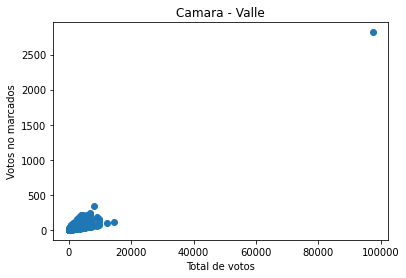

In [730]:
scatter(VOTOS,NO_MARCADOS)
xlabel('Total de votos')
ylabel('Votos no marcados')
title('Camara - Valle')

**Blanco**

In [731]:
x_obs = np.array(VOTOS)
y_obs = np.array(BLANCO)

In [732]:
for i in range(1,n_iteraciones):
    m_prime = np.random.normal(m_walk[i-1],0.05)
    b_prime = np.random.normal(b_walk[i-1],0.05)

    l_now = loglikelihood(x_obs,y_obs, m_walk[i-1], b_walk[i-1])
    l_next = loglikelihood(x_obs,y_obs, m_prime, b_prime)
    gamma = np.min([1.0,np.exp(l_next-l_now)])
    # print(gamma)

    alpha = np.random.random()
    if alpha<gamma:
        m_walk[i] = m_prime
        b_walk[i] = b_prime
    else:
        m_walk[i] = m_walk[i-1]
        b_walk[i] = b_walk[i-1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


In [733]:
m_best = np.mean(m_walk)
m_error = np.std(m_walk)
print(m_best, m_error)

0.054536266852235456 0.0005910432588060938


In [734]:
b_best = np.mean(b_walk)
b_error = np.std(b_walk)
print(b_best, b_error)

6.076463971884222 3.523430075999055


In [735]:
x_teorico = np.linspace(x_obs.min(), x_obs.max(),1000)
y_teorico = modelo(x_teorico, m_best, b_best)

Text(0.5, 1.0, 'Camara - Valle')

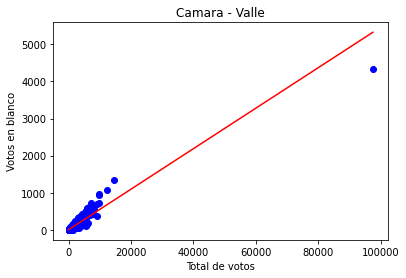

In [736]:
plt.scatter(VOTOS,BLANCO, c = 'b')
plt.plot(x_teorico, y_teorico, c = 'r')
xlabel('Total de votos')
ylabel('Votos en blanco')
title('Camara - Valle')

In [737]:
modelo(1515019+21904+80831,m_best,b_best)

88232.3403092432

In [738]:
77619+5687+15367

98673

**Nulo**

In [739]:
x_obs = np.array(VOTOS)
y_obs = np.array(NULOS)

In [740]:
for i in range(1,n_iteraciones):
    m_prime = np.random.normal(m_walk[i-1],0.05)
    b_prime = np.random.normal(b_walk[i-1],0.05)

    l_now = loglikelihood(x_obs,y_obs, m_walk[i-1], b_walk[i-1])
    l_next = loglikelihood(x_obs,y_obs, m_prime, b_prime)
    gamma = np.min([1.0,np.exp(l_next-l_now)])
    # print(gamma)

    alpha = np.random.random()
    if alpha<gamma:
        m_walk[i] = m_prime
        b_walk[i] = b_prime
    else:
        m_walk[i] = m_walk[i-1]
        b_walk[i] = b_walk[i-1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


In [741]:
m_best = np.mean(m_walk)
m_error = np.std(m_walk)
print(m_best, m_error)

0.08703036237339089 0.0007504697804826044


In [742]:
b_best = np.mean(b_walk)
b_error = np.std(b_walk)
print(b_best, b_error)

5.396329774078203 3.470336685577732


In [743]:
x_teorico = np.linspace(x_obs.min(), x_obs.max(),1000)
y_teorico = modelo(x_teorico, m_best, b_best)

Text(0.5, 1.0, 'Camara - Valle')

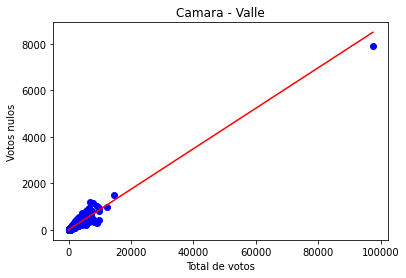

In [744]:
plt.scatter(VOTOS,NULOS, c = 'b')
plt.plot(x_teorico, y_teorico, c = 'r')
xlabel('Total de votos')
ylabel('Votos nulos')
title('Camara - Valle')

In [745]:
modelo(1515019+21904+80831,m_best,b_best)

140799.11318077668

In [754]:
64736+3189+10432

78357

**No marcado**

In [747]:
x_obs = np.array(VOTOS)
y_obs = np.array(NO_MARCADOS)

In [748]:
for i in range(1,n_iteraciones):
    m_prime = np.random.normal(m_walk[i-1],0.05)
    b_prime = np.random.normal(b_walk[i-1],0.05)

    l_now = loglikelihood(x_obs,y_obs, m_walk[i-1], b_walk[i-1])
    l_next = loglikelihood(x_obs,y_obs, m_prime, b_prime)
    gamma = np.min([1.0,np.exp(l_next-l_now)])
    # print(gamma)

    alpha = np.random.random()
    if alpha<gamma:
        m_walk[i] = m_prime
        b_walk[i] = b_prime
    else:
        m_walk[i] = m_walk[i-1]
        b_walk[i] = b_walk[i-1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


In [749]:
m_best = np.mean(m_walk)
m_error = np.std(m_walk)
print(m_best, m_error)

0.026250117942729495 0.00016610896873121118


In [750]:
b_best = np.mean(b_walk)
b_error = np.std(b_walk)
print(b_best, b_error)

-1.8649512002315582 0.7583012368987944


In [751]:
x_teorico = np.linspace(x_obs.min(), x_obs.max(),1000)
y_teorico = modelo(x_teorico, m_best, b_best)

Text(0.5, 1.0, 'Camara - Valle')

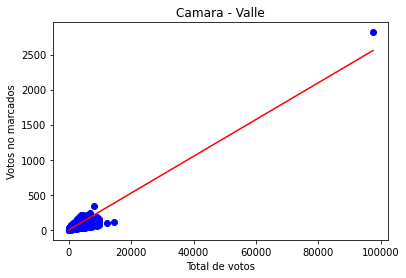

In [752]:
plt.scatter(VOTOS,NO_MARCADOS, c = 'b')
plt.plot(x_teorico, y_teorico, c = 'r')
xlabel('Total de votos')
ylabel('Votos no marcados')
title('Camara - Valle')

In [753]:
modelo(1515019+21904+80831,m_best,b_best)

42464.36835112218

In [755]:
25360+2039+6533

33932

In [756]:
V1 = requests.get('https://www.datos.gov.co/resource/75f2-fe2s.json?ndepto=ANTIOQUIA&$limit=500000&$order=npuesto ASC').text
V2 = requests.get('https://www.datos.gov.co/resource/75f2-fe2s.json?ndepto=ANTIOQUIA&$limit=500000&$offset=500000&$order=npuesto ASC').text

In [757]:
V1 = json.loads(V1)
shape(V1)

(500000,)

In [758]:
V2 = json.loads(V2)
shape(V2)

(145984,)

In [759]:
V = V1 + V2
shape(V)

(645984,)

In [760]:
n = V[0]['npuesto']
b_votos = 0
n_votos = 0
A = []
for i in V:
    if i['npuesto'] == n:
        n_votos += int(i['votos'])
        try:
            if i['candidato'] == 'VOTOS EN BLANCO':
                b_votos += int(i['votos'])
        except Exception:
            pass
    else:
        A.append([n,n_votos,b_votos])
        n = i['npuesto']
        n_votos = int(i['votos'])
        b_votos = 0
shape(A)

(867, 3)

In [761]:
n = V[0]['npuesto']
nulos_votos = 0
n_votos = 0
A2 = []
for i in V:
    if i['npuesto'] == n:
        n_votos += int(i['votos'])
        try:
            if i['candidato'] == 'VOTOS NULOS':
                nulos_votos += int(i['votos'])
        except Exception:
            pass
    else:
        A2.append([n,n_votos,nulos_votos])
        n = i['npuesto']
        n_votos = int(i['votos'])
        nulos_votos = 0
shape(A)

(867, 3)

In [762]:
n = V[0]['npuesto']
nmarcados_votos = 0
n_votos = 0
A3 = []
for i in V:
    if i['npuesto'] == n:
        n_votos += int(i['votos'])
        try:
            if i['candidato'] == 'VOTOS NO MARCADOS':
                nmarcados_votos += int(i['votos'])
        except Exception:
            pass
    else:
        A3.append([n,n_votos,nmarcados_votos])
        n = i['npuesto']
        n_votos = int(i['votos'])
        nmarcados_votos = 0
shape(A)

(867, 3)

In [763]:
A = np.array(A)
A2 = np.array(A2)
A3 = np.array(A3)
VOTOS = [int(x) for x in A[:,1]]
BLANCO = [int(x) for x in A[:,2]]
NULOS = [int(x) for x in A2[:,2]]
NO_MARCADOS = [int(x) for x in A3[:,2]]

Text(0.5, 1.0, 'Senado - Valle')

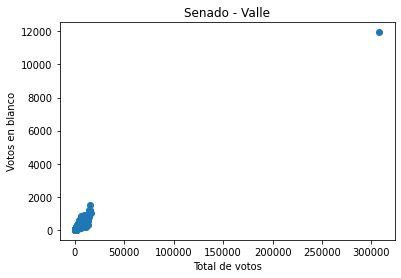

In [764]:
scatter(VOTOS,BLANCO)
xlabel('Total de votos')
ylabel('Votos en blanco')
title('Senado - Valle')

Text(0.5, 1.0, 'Senado - Valle')

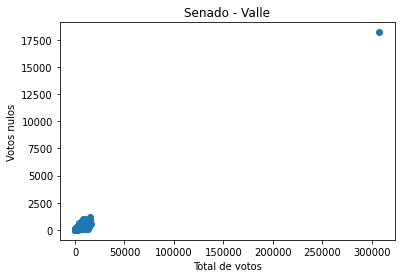

In [765]:
scatter(VOTOS,NULOS)
xlabel('Total de votos')
ylabel('Votos nulos')
title('Senado - Valle')

Text(0.5, 1.0, 'Senado - Valle')

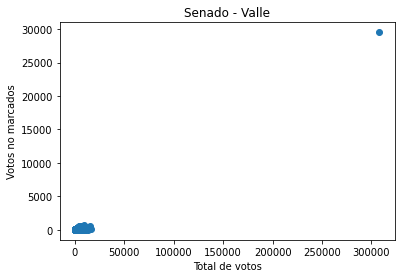

In [766]:
scatter(VOTOS,NO_MARCADOS)
xlabel('Total de votos')
ylabel('Votos no marcados')
title('Senado - Valle')

**Blanco**

In [767]:
x_obs = np.array(VOTOS)
y_obs = np.array(BLANCO)

In [768]:
for i in range(1,n_iteraciones):
    m_prime = np.random.normal(m_walk[i-1],0.05)
    b_prime = np.random.normal(b_walk[i-1],0.05)

    l_now = loglikelihood(x_obs,y_obs, m_walk[i-1], b_walk[i-1])
    l_next = loglikelihood(x_obs,y_obs, m_prime, b_prime)
    gamma = np.min([1.0,np.exp(l_next-l_now)])
    # print(gamma)

    alpha = np.random.random()
    if alpha<gamma:
        m_walk[i] = m_prime
        b_walk[i] = b_prime
    else:
        m_walk[i] = m_walk[i-1]
        b_walk[i] = b_walk[i-1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


In [769]:
m_best = np.mean(m_walk)
m_error = np.std(m_walk)
print(m_best, m_error)

0.04213771798831238 0.0003264192063953999


In [770]:
b_best = np.mean(b_walk)
b_error = np.std(b_walk)
print(b_best, b_error)

3.615869473273423 2.110040854860046


In [771]:
x_teorico = np.linspace(x_obs.min(), x_obs.max(),1000)
y_teorico = modelo(x_teorico, m_best, b_best)

Text(0.5, 1.0, 'Senado - Valle')

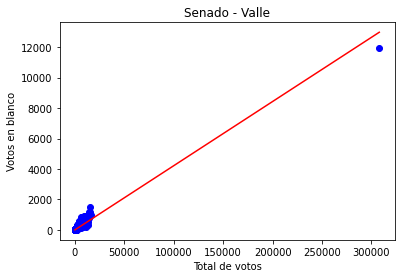

In [772]:
plt.scatter(VOTOS,BLANCO, c = 'b')
plt.plot(x_teorico, y_teorico, c = 'r')
xlabel('Total de votos')
ylabel('Votos en blanco')
title('Senado - Valle')

In [773]:
modelo(1524491+44504,m_best,b_best)

66117.48470454545

In [774]:
85500+13482

98982

**Nulo**

In [775]:
x_obs = np.array(VOTOS)
y_obs = np.array(NULOS)

In [776]:
for i in range(1,n_iteraciones):
    m_prime = np.random.normal(m_walk[i-1],0.05)
    b_prime = np.random.normal(b_walk[i-1],0.05)

    l_now = loglikelihood(x_obs,y_obs, m_walk[i-1], b_walk[i-1])
    l_next = loglikelihood(x_obs,y_obs, m_prime, b_prime)
    gamma = np.min([1.0,np.exp(l_next-l_now)])
    # print(gamma)

    alpha = np.random.random()
    if alpha<gamma:
        m_walk[i] = m_prime
        b_walk[i] = b_prime
    else:
        m_walk[i] = m_walk[i-1]
        b_walk[i] = b_walk[i-1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


In [777]:
m_best = np.mean(m_walk)
m_error = np.std(m_walk)
print(m_best, m_error)

0.05956137042770934 0.0002321718520604378


In [778]:
b_best = np.mean(b_walk)
b_error = np.std(b_walk)
print(b_best, b_error)

1.888132473614374 1.1073424572416792


In [779]:
x_teorico = np.linspace(x_obs.min(), x_obs.max(),1000)
y_teorico = modelo(x_teorico, m_best, b_best)

Text(0.5, 1.0, 'Senado - Valle')

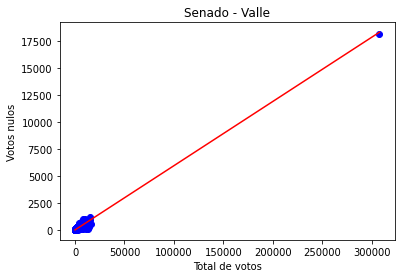

In [780]:
plt.scatter(VOTOS,NULOS, c = 'b')
plt.plot(x_teorico, y_teorico, c = 'r')
xlabel('Total de votos')
ylabel('Votos nulos')
title('Senado - Valle')

In [781]:
modelo(1524491+44504,m_best,b_best)

93453.38052669744

In [782]:
62954+9625

72579

**No marcado**

In [783]:
x_obs = np.array(VOTOS)
y_obs = np.array(NO_MARCADOS)

In [784]:
for i in range(1,n_iteraciones):
    m_prime = np.random.normal(m_walk[i-1],0.05)
    b_prime = np.random.normal(b_walk[i-1],0.05)

    l_now = loglikelihood(x_obs,y_obs, m_walk[i-1], b_walk[i-1])
    l_next = loglikelihood(x_obs,y_obs, m_prime, b_prime)
    gamma = np.min([1.0,np.exp(l_next-l_now)])
    # print(gamma)

    alpha = np.random.random()
    if alpha<gamma:
        m_walk[i] = m_prime
        b_walk[i] = b_prime
    else:
        m_walk[i] = m_walk[i-1]
        b_walk[i] = b_walk[i-1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


In [785]:
m_best = np.mean(m_walk)
m_error = np.std(m_walk)
print(m_best, m_error)

0.0907801992557817 0.0006374208536101131


In [786]:
b_best = np.mean(b_walk)
b_error = np.std(b_walk)
print(b_best, b_error)

-5.0839575783248305 2.8354768676206827


In [787]:
x_teorico = np.linspace(x_obs.min(), x_obs.max(),1000)
y_teorico = modelo(x_teorico, m_best, b_best)

Text(0.5, 1.0, 'Senado - Valle')

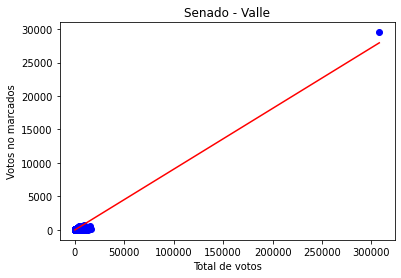

In [788]:
plt.scatter(VOTOS,NO_MARCADOS, c = 'b')
plt.plot(x_teorico, y_teorico, c = 'r')
xlabel('Total de votos')
ylabel('Votos no marcados')
title('Senado - Valle')

In [789]:
modelo(1524491+44504,m_best,b_best)

142428.59477374688

In [790]:
38186+6392

44578

# **Boyaca**

In [791]:
B1 = requests.get('https://www.datos.gov.co/resource/vkjr-c6fe.json?ndepto=BOYACA&$limit=500000&$order=npuesto ASC').text
B2 = requests.get('https://www.datos.gov.co/resource/vkjr-c6fe.json?ndepto=BOYACA&$limit=500000&$offset=500000&$order=npuesto ASC').text

In [792]:
B1 = json.loads(B1)
shape(B1)

(107652,)

In [793]:
B2 = json.loads(B2)
shape(B2)

(0,)

In [794]:
B = B1 + B2
shape(B)

(107652,)

In [795]:
n = B[0]['npuesto']
b_votos = 0
n_votos = 0
A = []
for i in B:
    if i['npuesto'] == n:
        n_votos += int(i['votos'])
        try:
            if i['candidato'] == 'VOTOS EN BLANCO':
                b_votos += int(i['votos'])
        except Exception:
            pass
    else:
        A.append([n,n_votos,b_votos])
        n = i['npuesto']
        n_votos = int(i['votos'])
        b_votos = 0
shape(A)

(246, 3)

In [796]:
n = B[0]['npuesto']
nulos_votos = 0
n_votos = 0
A2 = []
for i in B:
    if i['npuesto'] == n:
        n_votos += int(i['votos'])
        try:
            if i['candidato'] == 'VOTOS NULOS':
                nulos_votos += int(i['votos'])
        except Exception:
            pass
    else:
        A2.append([n,n_votos,nulos_votos])
        n = i['npuesto']
        n_votos = int(i['votos'])
        nulos_votos = 0
shape(A)

(246, 3)

In [797]:
n = B[0]['npuesto']
nmarcados_votos = 0
n_votos = 0
A3 = []
for i in B:
    if i['npuesto'] == n:
        n_votos += int(i['votos'])
        try:
            if i['candidato'] == 'VOTOS NO MARCADOS':
                nmarcados_votos += int(i['votos'])
        except Exception:
            pass
    else:
        A3.append([n,n_votos,nmarcados_votos])
        n = i['npuesto']
        n_votos = int(i['votos'])
        nmarcados_votos = 0
shape(A)

(246, 3)

In [798]:
A = np.array(A)
A2 = np.array(A2)
A3 = np.array(A3)
VOTOS = [int(x) for x in A[:,1]]
BLANCO = [int(x) for x in A[:,2]]
NULOS = [int(x) for x in A2[:,2]]
NO_MARCADOS = [int(x) for x in A3[:,2]]

Text(0.5, 1.0, 'Camara - Boyaca')

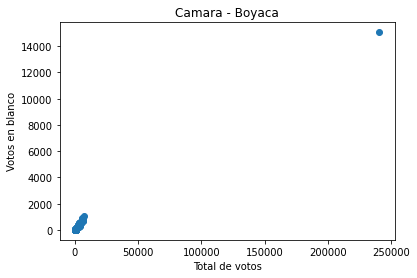

In [799]:
scatter(VOTOS,BLANCO)
xlabel('Total de votos')
ylabel('Votos en blanco')
title('Camara - Boyaca')

Text(0.5, 1.0, 'Camara - Boyaca')

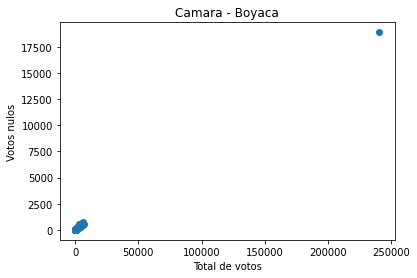

In [800]:
scatter(VOTOS,NULOS)
xlabel('Total de votos')
ylabel('Votos nulos')
title('Camara - Boyaca')

Text(0.5, 1.0, 'Camara - Boyaca')

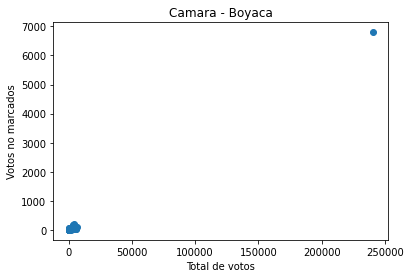

In [801]:
scatter(VOTOS,NO_MARCADOS)
xlabel('Total de votos')
ylabel('Votos no marcados')
title('Camara - Boyaca')

**Blanco**

In [802]:
x_obs = np.array(VOTOS)
y_obs = np.array(BLANCO)

In [803]:
for i in range(1,n_iteraciones):
    m_prime = np.random.normal(m_walk[i-1],0.05)
    b_prime = np.random.normal(b_walk[i-1],0.05)

    l_now = loglikelihood(x_obs,y_obs, m_walk[i-1], b_walk[i-1])
    l_next = loglikelihood(x_obs,y_obs, m_prime, b_prime)
    gamma = np.min([1.0,np.exp(l_next-l_now)])
    # print(gamma)

    alpha = np.random.random()
    if alpha<gamma:
        m_walk[i] = m_prime
        b_walk[i] = b_prime
    else:
        m_walk[i] = m_walk[i-1]
        b_walk[i] = b_walk[i-1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


In [804]:
m_best = np.mean(m_walk)
m_error = np.std(m_walk)
print(m_best, m_error)

0.06357057070575933 0.00047783262046028225


In [805]:
b_best = np.mean(b_walk)
b_error = np.std(b_walk)
print(b_best, b_error)

2.3465576806556037 1.3854641131717664


In [806]:
x_teorico = np.linspace(x_obs.min(), x_obs.max(),1000)
y_teorico = modelo(x_teorico, m_best, b_best)

Text(0.5, 1.0, 'Camara - Boyaca')

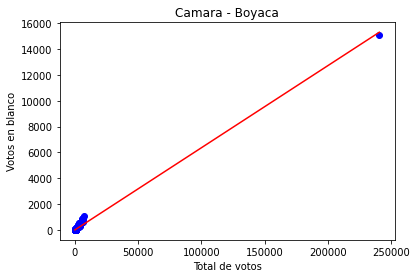

In [807]:
plt.scatter(VOTOS,BLANCO, c = 'b')
plt.plot(x_teorico, y_teorico, c = 'r')
xlabel('Total de votos')
ylabel('Votos en blanco')
title('Camara - Boyaca')

In [808]:
modelo(489635+2816+6937,m_best,b_best)

31748.726721288396

In [809]:
27175+919+1638

29732

**Nulo**

In [810]:
x_obs = np.array(VOTOS)
y_obs = np.array(NULOS)

In [811]:
for i in range(1,n_iteraciones):
    m_prime = np.random.normal(m_walk[i-1],0.05)
    b_prime = np.random.normal(b_walk[i-1],0.05)

    l_now = loglikelihood(x_obs,y_obs, m_walk[i-1], b_walk[i-1])
    l_next = loglikelihood(x_obs,y_obs, m_prime, b_prime)
    gamma = np.min([1.0,np.exp(l_next-l_now)])
    # print(gamma)

    alpha = np.random.random()
    if alpha<gamma:
        m_walk[i] = m_prime
        b_walk[i] = b_prime
    else:
        m_walk[i] = m_walk[i-1]
        b_walk[i] = b_walk[i-1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


In [812]:
m_best = np.mean(m_walk)
m_error = np.std(m_walk)
print(m_best, m_error)

0.07890394946666553 0.0006233768315585866


In [813]:
b_best = np.mean(b_walk)
b_error = np.std(b_walk)
print(b_best, b_error)

1.4171437996484892 0.757505720796384


In [814]:
x_teorico = np.linspace(x_obs.min(), x_obs.max(),1000)
y_teorico = modelo(x_teorico, m_best, b_best)

Text(0.5, 1.0, 'Camara - Boyaca')

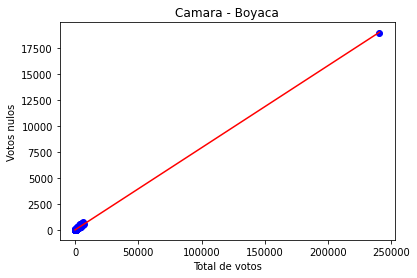

In [816]:
plt.scatter(VOTOS,NULOS, c = 'b')
plt.plot(x_teorico, y_teorico, c = 'r')
xlabel('Total de votos')
ylabel('Votos nulos')
title('Camara - Boyaca')

In [817]:
modelo(489635+2816+6937,m_best,b_best)

39405.102660058816

In [818]:
27891+837+1366

30094

**No marcado**

In [819]:
x_obs = np.array(VOTOS)
y_obs = np.array(NO_MARCADOS)

In [820]:
for i in range(1,n_iteraciones):
    m_prime = np.random.normal(m_walk[i-1],0.05)
    b_prime = np.random.normal(b_walk[i-1],0.05)

    l_now = loglikelihood(x_obs,y_obs, m_walk[i-1], b_walk[i-1])
    l_next = loglikelihood(x_obs,y_obs, m_prime, b_prime)
    gamma = np.min([1.0,np.exp(l_next-l_now)])
    # print(gamma)

    alpha = np.random.random()
    if alpha<gamma:
        m_walk[i] = m_prime
        b_walk[i] = b_prime
    else:
        m_walk[i] = m_walk[i-1]
        b_walk[i] = b_walk[i-1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


In [821]:
m_best = np.mean(m_walk)
m_error = np.std(m_walk)
print(m_best, m_error)

0.028101400269328898 0.00014275115490415218


In [822]:
b_best = np.mean(b_walk)
b_error = np.std(b_walk)
print(b_best, b_error)

-0.960784823782259 0.4714129757631403


In [823]:
x_teorico = np.linspace(x_obs.min(), x_obs.max(),1000)
y_teorico = modelo(x_teorico, m_best, b_best)

Text(0.5, 1.0, 'Camara - Boyaca')

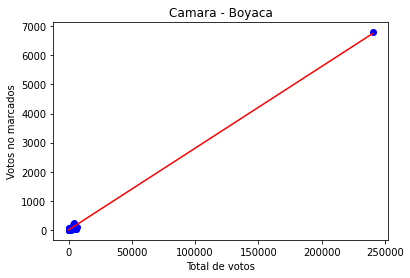

In [824]:
plt.scatter(VOTOS,NO_MARCADOS, c = 'b')
plt.plot(x_teorico, y_teorico, c = 'r')
xlabel('Total de votos')
ylabel('Votos no marcados')
title('Camara - Boyaca')

In [825]:
modelo(489635+2816+6937,m_best,b_best)

14032.541292875836

In [865]:
8599+256+542

9397

In [827]:
V1 = requests.get('https://www.datos.gov.co/resource/75f2-fe2s.json?ndepto=ANTIOQUIA&$limit=500000&$order=npuesto ASC').text
V2 = requests.get('https://www.datos.gov.co/resource/75f2-fe2s.json?ndepto=ANTIOQUIA&$limit=500000&$offset=500000&$order=npuesto ASC').text

In [828]:
V1 = json.loads(V1)
shape(V1)

(500000,)

In [829]:
V2 = json.loads(V2)
shape(V2)

(145984,)

In [830]:
V = V1 + V2
shape(V)

(645984,)

In [831]:
n = V[0]['npuesto']
b_votos = 0
n_votos = 0
A = []
for i in V:
    if i['npuesto'] == n:
        n_votos += int(i['votos'])
        try:
            if i['candidato'] == 'VOTOS EN BLANCO':
                b_votos += int(i['votos'])
        except Exception:
            pass
    else:
        A.append([n,n_votos,b_votos])
        n = i['npuesto']
        n_votos = int(i['votos'])
        b_votos = 0
shape(A)

(867, 3)

In [832]:
n = V[0]['npuesto']
nulos_votos = 0
n_votos = 0
A2 = []
for i in V:
    if i['npuesto'] == n:
        n_votos += int(i['votos'])
        try:
            if i['candidato'] == 'VOTOS NULOS':
                nulos_votos += int(i['votos'])
        except Exception:
            pass
    else:
        A2.append([n,n_votos,nulos_votos])
        n = i['npuesto']
        n_votos = int(i['votos'])
        nulos_votos = 0
shape(A)

(867, 3)

In [833]:
n = V[0]['npuesto']
nmarcados_votos = 0
n_votos = 0
A3 = []
for i in V:
    if i['npuesto'] == n:
        n_votos += int(i['votos'])
        try:
            if i['candidato'] == 'VOTOS NO MARCADOS':
                nmarcados_votos += int(i['votos'])
        except Exception:
            pass
    else:
        A3.append([n,n_votos,nmarcados_votos])
        n = i['npuesto']
        n_votos = int(i['votos'])
        nmarcados_votos = 0
shape(A)

(867, 3)

In [834]:
A = np.array(A)
A2 = np.array(A2)
A3 = np.array(A3)
VOTOS = [int(x) for x in A[:,1]]
BLANCO = [int(x) for x in A[:,2]]
NULOS = [int(x) for x in A2[:,2]]
NO_MARCADOS = [int(x) for x in A3[:,2]]

Text(0.5, 1.0, 'Senado - Boyaca')

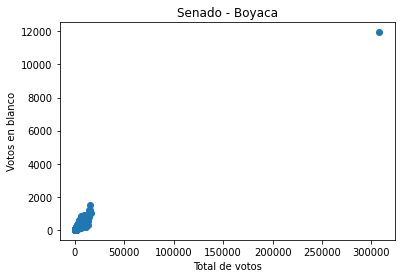

In [835]:
scatter(VOTOS,BLANCO)
xlabel('Total de votos')
ylabel('Votos en blanco')
title('Senado - Boyaca')

Text(0.5, 1.0, 'Senado - Boyaca')

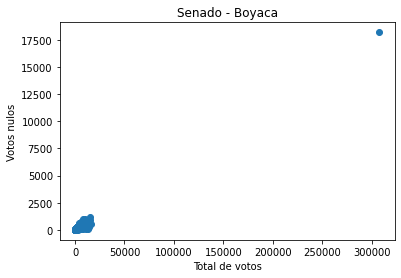

In [836]:
scatter(VOTOS,NULOS)
xlabel('Total de votos')
ylabel('Votos nulos')
title('Senado - Boyaca')

Text(0.5, 1.0, 'Senado - Boyaca')

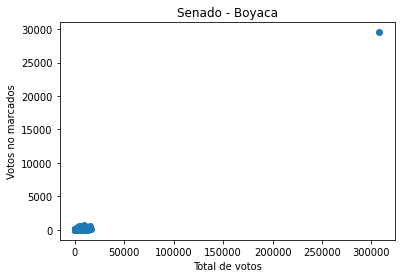

In [837]:
scatter(VOTOS,NO_MARCADOS)
xlabel('Total de votos')
ylabel('Votos no marcados')
title('Senado - Boyaca')

**Blanco**

In [838]:
x_obs = np.array(VOTOS)
y_obs = np.array(BLANCO)

In [839]:
for i in range(1,n_iteraciones):
    m_prime = np.random.normal(m_walk[i-1],0.05)
    b_prime = np.random.normal(b_walk[i-1],0.05)

    l_now = loglikelihood(x_obs,y_obs, m_walk[i-1], b_walk[i-1])
    l_next = loglikelihood(x_obs,y_obs, m_prime, b_prime)
    gamma = np.min([1.0,np.exp(l_next-l_now)])
    # print(gamma)

    alpha = np.random.random()
    if alpha<gamma:
        m_walk[i] = m_prime
        b_walk[i] = b_prime
    else:
        m_walk[i] = m_walk[i-1]
        b_walk[i] = b_walk[i-1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


In [840]:
m_best = np.mean(m_walk)
m_error = np.std(m_walk)
print(m_best, m_error)

0.04208962531078631 0.0004060294538446028


In [841]:
b_best = np.mean(b_walk)
b_error = np.std(b_walk)
print(b_best, b_error)

5.11719878549162 2.8088185495764937


In [842]:
x_teorico = np.linspace(x_obs.min(), x_obs.max(),1000)
y_teorico = modelo(x_teorico, m_best, b_best)

Text(0.5, 1.0, 'Senado - Boyaca')

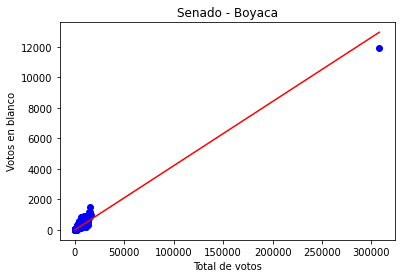

In [843]:
plt.scatter(VOTOS,BLANCO, c = 'b')
plt.plot(x_teorico, y_teorico, c = 'r')
xlabel('Total de votos')
ylabel('Votos en blanco')
title('Senado - Boyaca')

In [844]:
modelo(481553+5809,m_best,b_best)

20518.00116950093

In [845]:
38951+2378

41329

**Nulo**

In [846]:
x_obs = np.array(VOTOS)
y_obs = np.array(NULOS)

In [847]:
for i in range(1,n_iteraciones):
    m_prime = np.random.normal(m_walk[i-1],0.05)
    b_prime = np.random.normal(b_walk[i-1],0.05)

    l_now = loglikelihood(x_obs,y_obs, m_walk[i-1], b_walk[i-1])
    l_next = loglikelihood(x_obs,y_obs, m_prime, b_prime)
    gamma = np.min([1.0,np.exp(l_next-l_now)])
    # print(gamma)

    alpha = np.random.random()
    if alpha<gamma:
        m_walk[i] = m_prime
        b_walk[i] = b_prime
    else:
        m_walk[i] = m_walk[i-1]
        b_walk[i] = b_walk[i-1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


In [848]:
m_best = np.mean(m_walk)
m_error = np.std(m_walk)
print(m_best, m_error)

0.05955335643635121 0.0003972464145838281


In [849]:
b_best = np.mean(b_walk)
b_error = np.std(b_walk)
print(b_best, b_error)

1.8926375548024528 1.3248447697368049


In [850]:
x_teorico = np.linspace(x_obs.min(), x_obs.max(),1000)
y_teorico = modelo(x_teorico, m_best, b_best)

Text(0.5, 1.0, 'Senado - Boyaca')

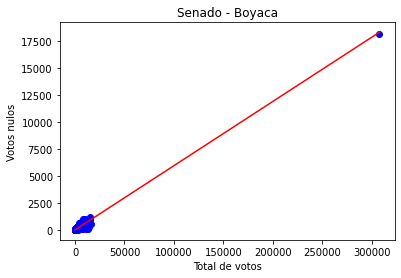

In [851]:
plt.scatter(VOTOS,NULOS, c = 'b')
plt.plot(x_teorico, y_teorico, c = 'r')
xlabel('Total de votos')
ylabel('Votos nulos')
title('Senado - Boyaca')

In [852]:
modelo(481553+5809,m_best,b_best)

29025.9355370878

In [853]:
22349+1270

23619

**No marcado**

In [854]:
x_obs = np.array(VOTOS)
y_obs = np.array(NO_MARCADOS)

In [855]:
for i in range(1,n_iteraciones):
    m_prime = np.random.normal(m_walk[i-1],0.05)
    b_prime = np.random.normal(b_walk[i-1],0.05)

    l_now = loglikelihood(x_obs,y_obs, m_walk[i-1], b_walk[i-1])
    l_next = loglikelihood(x_obs,y_obs, m_prime, b_prime)
    gamma = np.min([1.0,np.exp(l_next-l_now)])
    # print(gamma)

    alpha = np.random.random()
    if alpha<gamma:
        m_walk[i] = m_prime
        b_walk[i] = b_prime
    else:
        m_walk[i] = m_walk[i-1]
        b_walk[i] = b_walk[i-1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


In [856]:
m_best = np.mean(m_walk)
m_error = np.std(m_walk)
print(m_best, m_error)

0.09075853328805011 0.0005718244567651077


In [857]:
b_best = np.mean(b_walk)
b_error = np.std(b_walk)
print(b_best, b_error)

-4.960193928945192 3.087610406547909


In [858]:
x_teorico = np.linspace(x_obs.min(), x_obs.max(),1000)
y_teorico = modelo(x_teorico, m_best, b_best)

Text(0.5, 1.0, 'Senado - Boyaca')

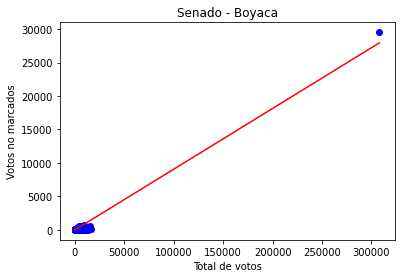

In [859]:
plt.scatter(VOTOS,NO_MARCADOS, c = 'b')
plt.plot(x_teorico, y_teorico, c = 'r')
xlabel('Total de votos')
ylabel('Votos no marcados')
title('Senado - Boyaca')

In [860]:
modelo(481553+5809,m_best,b_best)

44227.30010640174

In [861]:
19387+963

20350

# **Otros Partidos**

**Ajuste con otros partidos con CORFERIAS**

In [ ]:
n = B[0]['npuesto']
b_votos = 0

CD_votos = 0
PV_votos = 0
CR_votos = 0
UP_votos = 0
PL_votos = 0

n_votos = 0
A = []
for i in B:
    if i['npuesto'] == n:
        n_votos += int(i['votos'])
        try:
            if i['candidato'] == 'VOTOS EN BLANCO':
                b_votos += int(i['votos'])

            if i['partido'] == 'PARTIDO CENTRO DEMOCRÁTICO':
                CD_votos += 1
            elif i['partido'] == 'PARTIDO ALIANZA VERDE':
                PV_votos += 1
            elif i['partido'] == 'PARTIDO CAMBIO RADICAL':
                CR_votos += 1
            elif i['partido'] == 'COALICIÓN LISTA DE LA DECENCIA (ASI,UP,MAIS)':
                UP_votos += 1
            elif i['partido'] == 'PARTIDO POLO DEMOCRÁTICO ALTERNATIVO':
                PL_votos += 1

        except Exception:
            pass
    else:
        A.append([n,n_votos,b_votos,CD_votos,PV_votos,CR_votos,UP_votos,PL_votos])
        n = i['npuesto']
        n_votos = int(i['votos'])

        CD_votos = 0
        PV_votos = 0
        CR_votos = 0
        UP_votos = 0
        PL_votos = 0

        b_votos = 0
shape(A)

(641, 8)

In [ ]:
A = np.array(A)
VOTOS = [int(x) for x in A[:,1]]
BLANCO = [int(x) for x in A[:,2]]
CD = [int(x) for x in A[:,3]]
PV = [int(x) for x in A[:,4]]
CR = [int(x) for x in A[:,5]]
UP = [int(x) for x in A[:,6]]
PL = [int(x) for x in A[:,7]]

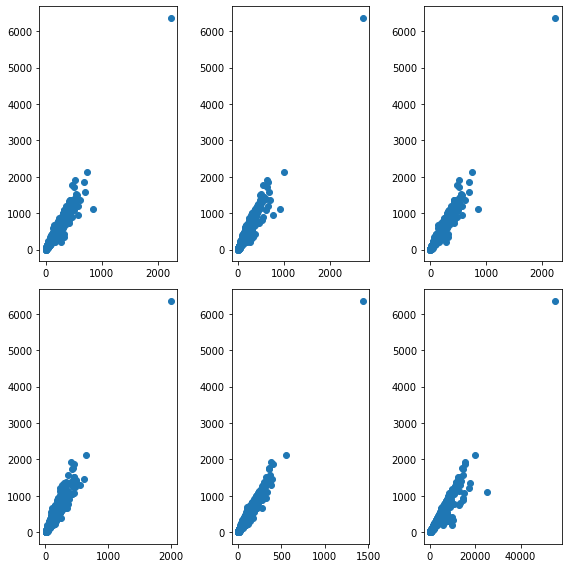

In [ ]:
figure(figsize=(8,8))
plt.subplot(2,3,1)
plt.scatter(CR,BLANCO)

plt.subplot(2,3,2)
plt.scatter(PV,BLANCO)

plt.subplot(2,3,3)
plt.scatter(CR,BLANCO)

plt.subplot(2,3,4)
plt.scatter(UP,BLANCO)

plt.subplot(2,3,5)
plt.scatter(PL,BLANCO)

plt.subplot(2,3,6)
plt.scatter(VOTOS,BLANCO)

tight_layout()

0.8533686128974379


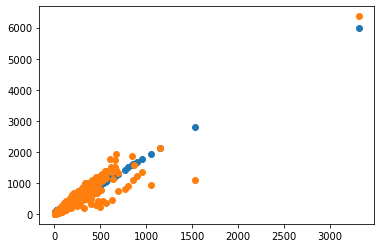

In [ ]:
Y = BLANCO
X = A[:,3:4].astype(int)
regression = sklearn.linear_model.LinearRegression()
regression.fit(X,Y)
y_predict = regression.predict(X)
score = regression.score(X,Y)
print(score)
plt.scatter(X[:,0],y_predict)
plt.scatter(X[:,0],Y)
# plt.title('Variable = {}, Score = {:.2f}'.format(name, score))

In [ ]:
regression.predict([[293044]])

array([524836.00627827])

In [ ]:
203889+10964+20717

235570

0.9334707726150645


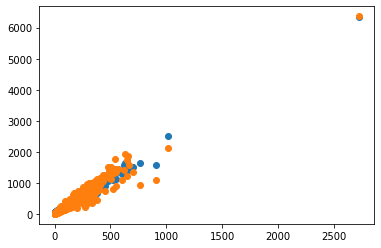

In [ ]:
Y = BLANCO
X = A[:,3:5].astype(int)
regression = sklearn.linear_model.LinearRegression()
regression.fit(X,Y)
y_predict = regression.predict(X)
score = regression.score(X,Y)
print(score)
plt.scatter(X[:,1],y_predict)
plt.scatter(X[:,1],Y)
# plt.title('Variable = {}, Score = {:.2f}'.format(name, score))

In [ ]:
regression.predict([[293044,396935]])

array([1183128.83254679])

0.96169145511565


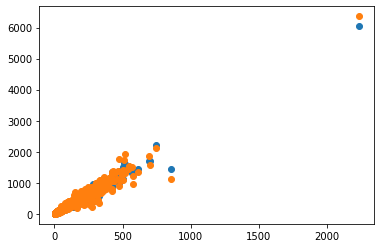

In [ ]:
Y = BLANCO
X = A[:,3:6].astype(int)
regression = sklearn.linear_model.LinearRegression()
regression.fit(X,Y)
y_predict = regression.predict(X)
score = regression.score(X,Y)
print(score)
plt.scatter(X[:,2],y_predict)
plt.scatter(X[:,2],Y)
# plt.title('Variable = {}, Score = {:.2f}'.format(name, score))

In [ ]:
regression.predict([[293044,396935,115977]])

array([791878.12971371])

0.9643774795038625


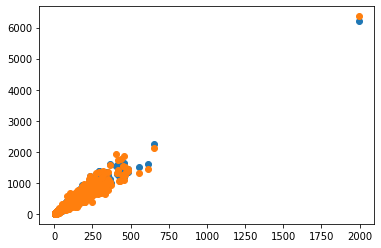

In [ ]:
Y = BLANCO
X = np.array(A[:,3:7].astype(int))
regression = sklearn.linear_model.LinearRegression()
regression.fit(X,Y)
y_predict = regression.predict(X)
score = regression.score(X,Y)
print(score)
plt.scatter(X[:,3],y_predict)
plt.scatter(X[:,3],Y)
# plt.title('Variable = {}, Score = {:.2f}'.format(name, score))

In [ ]:
regression.predict([[293044,396935,115977,816070]])

array([1218267.18882015])

0.9677198032235163


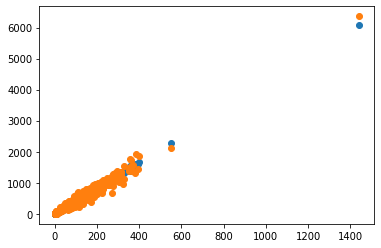

In [ ]:
Y = BLANCO
X = np.array(A[:,3:].astype(int))
regression = sklearn.linear_model.LinearRegression()
regression.fit(X,Y)
y_predict = regression.predict(X)
score = regression.score(X,Y)
print(score)
plt.scatter(X[:,4],y_predict)
plt.scatter(X[:,4],Y)
# plt.title('Variable = {}, Score = {:.2f}'.format(name, score))

**Ajuste con otros partidos sin CORFERIAS**

In [ ]:
n = B[0]['npuesto']
b_votos = 0

CD_votos = 0
PV_votos = 0
CR_votos = 0
UP_votos = 0
PL_votos = 0

n_votos = 0
A = []
for i in B:
    if n != 'PUESTO CENSO(FERIA EXPOSICION':
        if i['npuesto'] == n:
            n_votos += int(i['votos'])
            try:
                if i['candidato'] == 'VOTOS EN BLANCO':
                    b_votos += int(i['votos'])

                if i['partido'] == 'PARTIDO CENTRO DEMOCRÁTICO':
                    CD_votos += 1
                elif i['partido'] == 'PARTIDO ALIANZA VERDE':
                    PV_votos += 1
                elif i['partido'] == 'PARTIDO CAMBIO RADICAL':
                    CR_votos += 1
                elif i['partido'] == 'COALICIÓN LISTA DE LA DECENCIA (ASI,UP,MAIS)':
                    UP_votos += 1
                elif i['partido'] == 'PARTIDO POLO DEMOCRÁTICO ALTERNATIVO':
                    PL_votos += 1

            except Exception:
                pass
        else:
            A.append([n,n_votos,b_votos,CD_votos,PV_votos,CR_votos,UP_votos,PL_votos])
            n = i['npuesto']
            n_votos = int(i['votos'])

            CD_votos = 0
            PV_votos = 0
            CR_votos = 0
            UP_votos = 0
            PL_votos = 0

            b_votos = 0
shape(A)

(460, 8)

In [ ]:
A = np.array(A)
VOTOS = [int(x) for x in A[:,1]]
BLANCO = [int(x) for x in A[:,2]]
CD = [int(x) for x in A[:,3]]
PV = [int(x) for x in A[:,4]]
CR = [int(x) for x in A[:,5]]
UP = [int(x) for x in A[:,6]]
PL = [int(x) for x in A[:,7]]

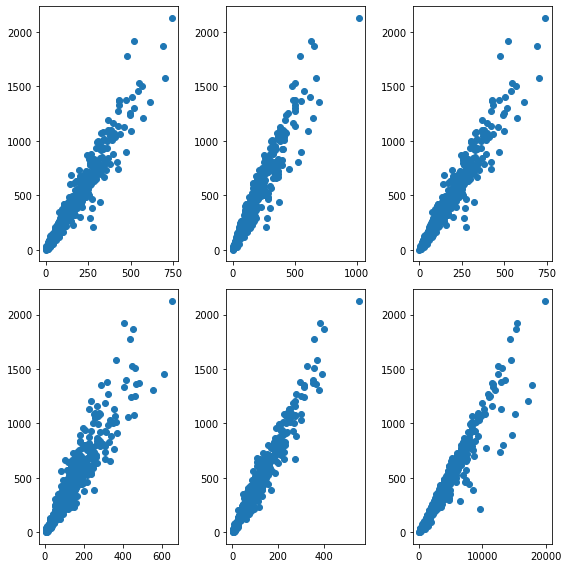

In [ ]:
figure(figsize=(8,8))
plt.subplot(2,3,1)
plt.scatter(CR,BLANCO)

plt.subplot(2,3,2)
plt.scatter(PV,BLANCO)

plt.subplot(2,3,3)
plt.scatter(CR,BLANCO)

plt.subplot(2,3,4)
plt.scatter(UP,BLANCO)

plt.subplot(2,3,5)
plt.scatter(PL,BLANCO)

plt.subplot(2,3,6)
plt.scatter(VOTOS,BLANCO)

tight_layout()

0.84434254320749


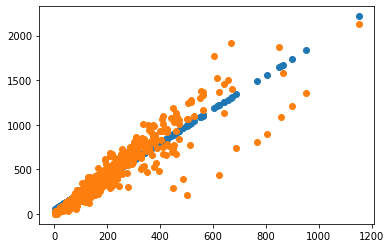

In [ ]:
Y = BLANCO
X = A[:,3:4].astype(int)
regression = sklearn.linear_model.LinearRegression()
regression.fit(X,Y)
y_predict = regression.predict(X)
score = regression.score(X,Y)
print(score)
plt.scatter(X[:,0],y_predict)
plt.scatter(X[:,0],Y)
# plt.title('Variable = {}, Score = {:.2f}'.format(name, score))

In [ ]:
regression.predict([[293044]])

array([551664.28697834])

0.914028455751541


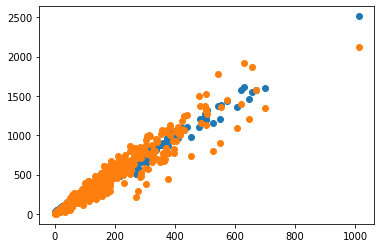

In [ ]:
Y = BLANCO
X = A[:,3:5].astype(int)
regression = sklearn.linear_model.LinearRegression()
regression.fit(X,Y)
y_predict = regression.predict(X)
score = regression.score(X,Y)
print(score)
plt.scatter(X[:,1],y_predict)
plt.scatter(X[:,1],Y)
# plt.title('Variable = {}, Score = {:.2f}'.format(name, score))

In [ ]:
regression.predict([[293044,396935]])

array([1124268.29821811])

0.9511546617149893


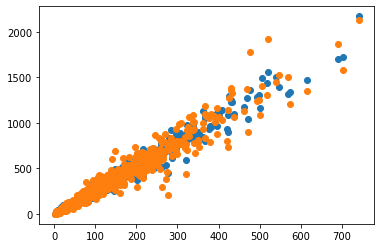

In [ ]:
Y = BLANCO
X = A[:,3:6].astype(int)
regression = sklearn.linear_model.LinearRegression()
regression.fit(X,Y)
y_predict = regression.predict(X)
score = regression.score(X,Y)
print(score)
plt.scatter(X[:,2],y_predict)
plt.scatter(X[:,2],Y)
# plt.title('Variable = {}, Score = {:.2f}'.format(name, score))

In [ ]:
regression.predict([[293044,396935,115977]])

array([726788.90582536])

0.9533095726794939


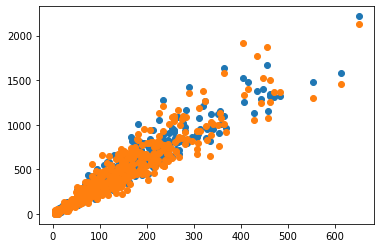

In [ ]:
Y = BLANCO
X = np.array(A[:,3:7].astype(int))
regression = sklearn.linear_model.LinearRegression()
regression.fit(X,Y)
y_predict = regression.predict(X)
score = regression.score(X,Y)
print(score)
plt.scatter(X[:,3],y_predict)
plt.scatter(X[:,3],Y)
# plt.title('Variable = {}, Score = {:.2f}'.format(name, score))

In [ ]:
regression.predict([[293044,396935,115977,816070]])

array([1072259.86051671])

0.9580027860788622


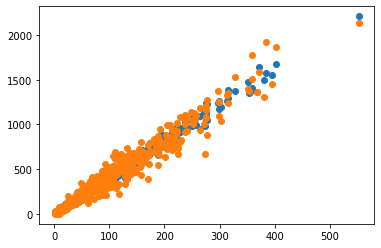

In [ ]:
Y = BLANCO
X = np.array(A[:,3:].astype(int))
regression = sklearn.linear_model.LinearRegression()
regression.fit(X,Y)
y_predict = regression.predict(X)
score = regression.score(X,Y)
print(score)
plt.scatter(X[:,4],y_predict)
plt.scatter(X[:,4],Y)
# plt.title('Variable = {}, Score = {:.2f}'.format(name, score))